# Modeling

This notebook will perform the modeling using many insights and findings from EDA. This includes the appropriate feature engineering techniques, depending on the model. It is worth noting that many iterations and attempts at different techniques have been attempted but for the sake of succinctiness I have tried to pare it down to final results/decisions.

The approach is fairly straightforward 
1) We will engineer features and preprocess data in a way that is appropriate for the types of models we will test. In this project, there are two approaches: one for linear modeling and one for tree based modeling. Included in this process is feature selection, for which we will use a few differernt methods including VIF, Mutual Information, and SHAP values.
2) Next, we fit a handful of baseline models that use differrent strategies/errors in an attempt to both maximize our ability to capture email clicks as well as maximize profit margin. 
2) We will choose from the baseline models the ones we believe to have most potential for high performance after tuning. This will be based on model stability and performance, as well as complexity and speed.
3) We will tune each model to maximize f1, the harmonic mean between Precision and Recall. During this process we will visualize our results to ensure model stability. After tuning is complete, we will ensure proper probability calibration.
4) Once the models are calibrated, we can use our profit optimizer to sweep over decision thresholds to find what will give us our best bet at maximizing profits given cost/revenue associated with emails and clicks. We will compare this to a Dummy classifier to see what the risk would be for not using a ML solution for this business problem.
5) Before observing test performance we will see if ensembling the models creates a more powerful classifier. In this case, they did not, or at the very least were comparable and so we choose to use less complexity in favor of interpretability and simplicity.
6) We will use our trained models to observe performance on our hold out test data and decide which model is most appropriate for our use case. We can do so by producing visualizations showing tradeoffs between the models and putting the results in terms of the business problem, which is money made

### Brief summary of results
* Our candidate models include a Random Forest, Histogram Gradient Boosting learner, and an XGBoost model
* Many features were not included in the model after considering their inability to make a meaningful contribution to prediction
    * Most important features include Word Count, Total Past Communication, Subject Hotness, Campaign Type==2
        * Interactions between these features as well as being univariately impactful
* I will recommend using a XGBoost for this business use case due to the higher profit optimization while maintaining best model stability, F1 score, and AUC-PR. I believe it has best potential for long term success.
* All models perform similarly when it comes to F1 and profit margin metrics, but XGBoost was more stable and performed best on unseen data
    * Probability thresholds differ by model: RandomForest: 17%, HGB: 18%, XGBoost: 17%
    * F1 around 50%, expected profit per email send around $.05-%0.052 (given $0.15/email cost and $0.75 Revenue/click, which I made up for the project)
        * Dummy Model essentially breaks even, but in real life this is hardly an assumption we could comfortably make

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load data
camp_df = pd.read_csv('data/email_camp_data.csv')

First we will split our data. I prefer to use both a validation and a test set, each 50% of the size of the original test set. We will tune based on the validation set. Final result will be based on the test set.

In [3]:
seed = 23

X_train, X_test, y_train, y_test = train_test_split(
    camp_df.drop(columns = ['Email_Status','Email_ID']), camp_df["Email_Status"], test_size=0.2, random_state=seed, stratify=camp_df["Email_Status"])

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=23, stratify=y_test)

In [4]:
X_train.columns

Index(['Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Customer_Location', 'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links',
       'Total_Images'],
      dtype='object')

## Feature Selection - Linear Models

Logistic Regression is a linear model we can use as a quick baseline. Ideally we get a great fit and can use it for our model, but this will not be the case this time. 

Linear models have many assumptions and are less flexible as far as input data goes compared to tree-based models, although the tradeoff is interpretability and ability to quickly perform statistical analysis and inference using confidence intervals and hypothesis testing on model parameters and results.

For this data, we need to do 2 things:
1) Try to extract as much signal from the data as possible via interactions that the linear model can pick up on. 
    * Tree-based models won't need this because they are designed for this exact purpose. But linear models are highly dependent on the data as it appears in its matrix form.
2) Engineer our features so that they can more easily allow the model to meet assumptioins, which for logistic regresion are:
    * Normalizing skewed numerical features
        * Some of our count data are skewed and we can use log transformations to normalize them
    * No multicollinearity
        * We want to avoid the scenario where two features correlate with one another or else the model will struggle to figure out where the signal is coming from
    * Linear relationship between logit and continuous features

In [8]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [264]:
# # First we will impute missing values for total past communications with KNN, then we can apply our interaction logic discussed previously using this imputed value
# imputer = KNNImputer(n_neighbors=5)
# X_train_lin["Total_Past_Communications"] = imputer.fit_transform(X_train_lin[["Total_Past_Communications"]])
# X_train_lin["Hotness1_4_CampType1_3"] = (((X_train_lin["Subject_Hotness_Score"] < 1) | (X_train_lin["Subject_Hotness_Score"] >= 4)) & (X_train_lin["Email_Campaign_Type"] != 2)).astype(int)
# X_train_lin["Word_Count400"] = (X_train_lin["Word_Count"] < 400).astype(int)
# X_train_lin["PastComm0_40"] = (((X_train_lin["Total_Past_Communications"] >= 40) | (X_train_lin["Total_Past_Communications"] == 0))).astype(int)
# X_train_lin["Source1_PastComm50_Type1"] = ((X_train_lin["Email_Source_Type"] == 1) & (X_train_lin["Total_Past_Communications"] >= 50) & (X_train_lin["Email_Type"] == 1)).astype(int)
# X_train_lin["CampType3_PastComm30_WordCount400"] = ((X_train_lin["Email_Campaign_Type"] == 3) & ((X_train_lin["Total_Past_Communications"] >= 30) | (X_train_lin["Word_Count"] < 400))).astype(int)

# # Below we will define our feature engineering pipeline for the linear model
# numeric_preprocessor = ColumnTransformer([
#     # Links are right skewed so we will use a log transformation to center it and stabilize the variance
#     ('links_pipe', Pipeline([
#         ('imputer', KNNImputer(n_neighbors=5)),  
#         ('log_trans', FunctionTransformer(func=np.log1p)),
#         ('scaler', StandardScaler())
#     ]), ['Total_Links']),  

#     ('comms', StandardScaler(), ["Total_Past_Communications", 'Word_Count']),

#     # Linear models consider ordinal data continuous anyways, so binning them may/maynot make a difference. 
#     # I'll leave them as is and just normalize them. Also need to log transform them because they are right skewed.
#     # I did try binning these and it did not make a meaningful difference in model performance.
#     ('hot_pipe', Pipeline([
#         ('round', FunctionTransformer(np.log1p)),
#         ('scale', StandardScaler())
#     ]), ['Subject_Hotness_Score']),  

#     # Impute missing values for total images. It is also very skewed due to how many 0's there are.
#     # We could binarize this data, but there isn't really a difference in click outcome so it won't offer much signal.
#     # I'll include it just to see results from VIF and MI in the sections to follow, then we will drop it.
#     ('zero_image', Pipeline([
#         ('impute', KNNImputer(n_neighbors=5)),
#         ('log_trans', FunctionTransformer(func=np.log1p)),
#         ('scaler', StandardScaler())
#         ]), ['Total_Images'])
# ])

# # Impute missing locations with a new label 'Unknown'
# # OHE for all categoricals
# categorical_processor = ColumnTransformer([
#     ('location_pipe', Pipeline([
#         ('location_impute', SimpleImputer(strategy='constant', fill_value='Unknown')),  
#         ('encoder', OneHotEncoder(sparse_output=False))
#     ]), ['Customer_Location']),
#     ('encoder', OneHotEncoder(sparse_output=False),['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type', 'Time_Email_sent_Category'])
# ])

# # Combine everything into a final preprocessor
# preprocessor = ColumnTransformer(
#         transformers=[
#             ('num_pipe', numeric_preprocessor, ['Total_Links','Subject_Hotness_Score','Total_Images', 'Total_Past_Communications', 'Word_Count']),
#             ('cat_pipe', categorical_processor, ['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type', 'Time_Email_sent_Category','Customer_Location']),
#         ],
#         remainder='passthrough'
#         )

# preprocessor.set_output(transform='pandas')
# X_train_lin = preprocessor.fit_transform(X_train_lin)
# X_train_lin

In [325]:
# First we will impute missing values for total past communications with KNN, then we can apply our interaction logic discussed previously using this imputed value
# imputer = KNNImputer(n_neighbors=5)
# X_train_lin["Total_Past_Communications"] = imputer.fit_transform(X_train_lin[["Total_Past_Communications"]])
X_train_lin = X_train.reset_index(drop=True)
# Below we will define our feature engineering pipeline for the linear model
numeric_preprocessor = ColumnTransformer([
    # Links are right skewed so we will use a log transformation to center it and stabilize the variance
    ('pastcomm', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ]), ["Total_Past_Communications"]),
    
    ('links_pipe', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),  
        ('log_trans', FunctionTransformer(func=np.log1p)),
        ('scaler', StandardScaler())
    ]), ['Total_Links']),  

    ('comms', StandardScaler(), ['Word_Count']),

    # Linear models consider ordinal data continuous anyways, so binning them may/maynot make a difference. 
    # I'll leave them as is and just normalize them. Also need to log transform them because they are right skewed.
    # I did try binning these and it did not make a meaningful difference in model performance.
    ('hot_pipe', Pipeline([
        ('round', FunctionTransformer(np.log1p)),
        ('scale', StandardScaler())
    ]), ['Subject_Hotness_Score']),  

    # Impute missing values for total images. It is also very skewed due to how many 0's there are.
    # We could binarize this data, but there isn't really a difference in click outcome so it won't offer much signal.
    # I'll include it just to see results from VIF and MI in the sections to follow, then we will drop it.
    ('zero_image', Pipeline([
        ('impute', KNNImputer(n_neighbors=5)),
        ('log_trans', FunctionTransformer(func=np.log1p)),
        ('scaler', StandardScaler())
        ]), ['Total_Images'])
])

# Impute missing locations with a new label 'Unknown'
# OHE for all categoricals
categorical_processor = ColumnTransformer([
    ('location_pipe', Pipeline([
        ('location_impute', SimpleImputer(strategy='constant', fill_value='Unknown')),  
        ('encoder', OneHotEncoder(sparse_output=False))
    ]), ['Customer_Location']),
    ('encoder', OneHotEncoder(sparse_output=False),['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type', 'Time_Email_sent_Category'])
])

# Combine everything into a final preprocessor
preprocessor = ColumnTransformer(
        transformers=[
            ('num_pipe', numeric_preprocessor, ['Total_Links','Subject_Hotness_Score','Total_Images', 'Total_Past_Communications', 'Word_Count']),
            ('cat_pipe', categorical_processor, ['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type', 'Time_Email_sent_Category','Customer_Location']),
        ],
        remainder='passthrough'
        )

preprocessor.set_output(transform='pandas')
X_train_lin = preprocessor.fit_transform(X_train_lin)
X_train_lin.columns = X_train_lin.columns.str.split('__').str[-1]
X_train_lin

poly_preprocess = ColumnTransformer(
    [('poly', PolynomialFeatures(degree=2,interaction_only=True,include_bias=False), ["Total_Past_Communications", "Word_Count", "Email_Campaign_Type_2", "Subject_Hotness_Score"])],
    remainder='passthrough'
)

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly_preprocess', poly_preprocess)
#     # ('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))
# ])

poly_preprocess.set_output(transform='pandas')
X_train_lin = poly_preprocess.fit_transform(X_train_lin)
X_train_lin.columns = X_train_lin.columns.str.split('__').str[-1]
X_train_lin

,Total_Past_Communications,Word_Count,Email_Campaign_Type_2,Subject_Hotness_Score,Total_Past_Communications Word_Count,Total_Past_Communications Email_Campaign_Type_2,Total_Past_Communications Subject_Hotness_Score,Word_Count Email_Campaign_Type_2,Word_Count Subject_Hotness_Score,Email_Campaign_Type_2 Subject_Hotness_Score,...,Customer_Location_Unknown,Email_Type_1,Email_Type_2,Email_Source_Type_1,Email_Source_Type_2,Email_Campaign_Type_1,Email_Campaign_Type_3,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3
0,0.000000,0.003614,0.0,-0.985673,0.000000,0.000000,-0.000000,0.000000,-0.003562,-0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-1.258660,-0.232138,1.0,1.356068,0.292183,-1.258660,-1.706829,-0.232138,-0.314795,1.356068,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.760359,0.290937,1.0,-0.648446,0.221217,0.760359,-0.493052,0.290937,-0.188657,-0.648446,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.333276,0.290937,0.0,-0.985673,-0.096963,-0.000000,0.328501,0.000000,-0.286769,-0.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.349240,-0.232138,0.0,-1.384527,-0.313210,0.000000,-1.868059,-0.000000,0.321402,-0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54677,0.087353,-0.232138,0.0,-0.985673,-0.020278,0.000000,-0.086101,-0.000000,0.228812,-0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
54678,0.003227,0.080970,0.0,-1.176022,0.000261,0.000000,-0.003795,0.000000,-0.095223,-0.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
54679,-1.258660,-0.644705,0.0,-0.810568,0.811465,-0.000000,1.020230,-0.000000,0.522577,-0.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
54680,0.000000,-0.018488,1.0,-0.497515,-0.000000,0.000000,-0.000000,-0.018488,0.009198,-0.497515,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [266]:
X_train_lin.columns

Index(['Total_Past_Communications', 'Word_Count', 'Email_Campaign_Type_2',
       'Subject_Hotness_Score', 'Total_Past_Communications Word_Count',
       'Total_Past_Communications Email_Campaign_Type_2',
       'Total_Past_Communications Subject_Hotness_Score',
       'Word_Count Email_Campaign_Type_2', 'Word_Count Subject_Hotness_Score',
       'Email_Campaign_Type_2 Subject_Hotness_Score', 'Total_Links',
       'Total_Images', 'Customer_Location_A', 'Customer_Location_B',
       'Customer_Location_C', 'Customer_Location_D', 'Customer_Location_E',
       'Customer_Location_F', 'Customer_Location_G',
       'Customer_Location_Unknown', 'Email_Type_1', 'Email_Type_2',
       'Email_Source_Type_1', 'Email_Source_Type_2', 'Email_Campaign_Type_1',
       'Email_Campaign_Type_3', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

In [ ]:
# Links is approx normal now
sns.displot(X_train_lin["num_pipe__links_pipe__Total_Links"], bins = 10)

In [ ]:
# Subject hotness is not approx normal, which could cause issues for linear model. 
sns.displot(X_train_lin["num_pipe__hot_pipe__Subject_Hotness_Score"], bins = 10)

In [ ]:
# also not normally distributed
sns.displot(X_train_lin["num_pipe__zero_image__Total_Images"], bins = 10)

### VIF - variance inflation factor
To measure multicollinearity we will need to transform our variables, and we will need to drop a column from each of the one hot encoded variables or else we will get perfect multicollinearity.
* For Mutual Information we will need to bring back those fields

In [49]:
vif_data = X_train_lin.drop(columns = ['Customer_Location_A','Email_Type_1',
                                           'Email_Source_Type_1','Email_Campaign_Type_1',
                                           'Time_Email_sent_Category_1']).copy()

* We do have some colinearity between a few predictors. We will drop these since they can be explained by other variables. We can arbitrarily set a threshold. 3 is common but I'll make it 3.5 because I want to keep total past communications.
* Other than the feature representing the highest score, our interactions are not correlated which is good news! Hopefully they have good mutual information too.
* It is not surprising that so many of the locations are high scoring here since we saw in the EDA they behave very similarly. Makes sense that they'd be able to predict one another.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume X is your feature DataFrame
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Example usage
vif_df = compute_vif(X=vif_data).round(1).sort_values('VIF',ascending=False)
vif_df

In [ ]:
X_train_lin = X_train_lin.drop(columns=vif_df[vif_df["VIF"] >= 3.5]['Feature'])
# X_train_lite_fe_vif = X_train_lin.copy()

### Mutual Information - Linear
We will measure the mutual information of our primarily uncorrelated features we gathered from VIF. We need to calculate them separately for discrete and continuous features.

* There is not a lot of signal in this data. Of the little there is, Past communications seems to be the best of them.
* We will only keep a handful of features. And we don't expect a linear model to do well here.


In [326]:
from sklearn.feature_selection import mutual_info_classif
continuous = ['Total_Past_Communications', 'Word_Count',
       'Subject_Hotness_Score', 'Total_Past_Communications Word_Count',
       'Total_Past_Communications Email_Campaign_Type_2',
       'Total_Past_Communications Subject_Hotness_Score',
       'Word_Count Email_Campaign_Type_2', 'Word_Count Subject_Hotness_Score',
       'Email_Campaign_Type_2 Subject_Hotness_Score', 'Total_Links',
       'Total_Images']
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X_train_lin[continuous], y_train, discrete_features=False)  # Set True if categorical features

# Convert to a DataFrame for better visualization
mi_scores_df_cont = pd.DataFrame({'Feature': continuous, 'MI Score': np.round(mi_scores,3)})
mi_scores_df_cont = mi_scores_df_cont.sort_values(by="MI Score", ascending=False)

# Display results
mi_scores_df_cont

,Feature,MI Score
5,Total_Past_Communications Subject_Hotness_Score,0.064
3,Total_Past_Communications Word_Count,0.061
6,Word_Count Email_Campaign_Type_2,0.060
7,Word_Count Subject_Hotness_Score,0.059
0,Total_Past_Communications,0.056
4,Total_Past_Communications Email_Campaign_Type_2,0.040
8,Email_Campaign_Type_2 Subject_Hotness_Score,0.038
1,Word_Count,0.026
2,Subject_Hotness_Score,0.023
9,Total_Links,0.020


In [327]:
disc_feat = [i for i in X_train_lin.columns if i not in continuous]
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X_train_lin[disc_feat], y_train, discrete_features=True)  # Set True if categorical features

# Convert to a DataFrame for better visualization
mi_scores_df = pd.DataFrame({'Feature': X_train_lin[disc_feat].columns, 'MI Score': np.round(mi_scores,3)})
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)

# Display results
mi_scores_df

,Feature,MI Score
0,Email_Campaign_Type_2,0.033
14,Email_Campaign_Type_3,0.024
13,Email_Campaign_Type_1,0.012
1,Customer_Location_A,0.000
16,Time_Email_sent_Category_2,0.000
15,Time_Email_sent_Category_1,0.000
12,Email_Source_Type_2,0.000
11,Email_Source_Type_1,0.000
10,Email_Type_2,0.000
9,Email_Type_1,0.000


We see which fields we knew were anecdotally closely related to the click result:
* How many emails theyve received in the past
* How many words are in the email
* What the subject hotness is
* If they are in the 3rd campaign group and had more than 30 past emails and had fewer than 400 words
* If they had either no past communication or more than 40 past emails

We will keep any non-zero feature

In [330]:
# features = mi_scores_df_cont[(mi_scores_df_cont["MI Score"] >= .01)]["Feature"].to_list()
# features.extend(mi_scores_df[(mi_scores_df["MI Score"] >= .01)]["Feature"].to_list())
features = pd.concat([mi_scores_df_cont,mi_scores_df]).sort_values("MI Score",ascending=False).head(12)
features

,Feature,MI Score
5,Total_Past_Communications Subject_Hotness_Score,0.064
3,Total_Past_Communications Word_Count,0.061
6,Word_Count Email_Campaign_Type_2,0.060
7,Word_Count Subject_Hotness_Score,0.059
0,Total_Past_Communications,0.056
4,Total_Past_Communications Email_Campaign_Type_2,0.040
8,Email_Campaign_Type_2 Subject_Hotness_Score,0.038
0,Email_Campaign_Type_2,0.033
1,Word_Count,0.026
14,Email_Campaign_Type_3,0.024


In [331]:
X_train_lin = X_train_lin[features["Feature"]].copy()

In [332]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume X is your feature DataFrame
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Example usage
vif_df = compute_vif(X=X_train_lin).round(1).sort_values('VIF',ascending=False)
vif_df

,Feature,VIF
10,Subject_Hotness_Score,43.9
6,Email_Campaign_Type_2 Subject_Hotness_Score,30.4
9,Email_Campaign_Type_3,17.5
2,Word_Count Email_Campaign_Type_2,8.6
4,Total_Past_Communications,7.6
5,Total_Past_Communications Email_Campaign_Type_2,7.6
8,Word_Count,6.9
0,Total_Past_Communications Subject_Hotness_Score,3.2
3,Word_Count Subject_Hotness_Score,2.6
7,Email_Campaign_Type_2,1.7


In [333]:
# Transform our validation set and filter to relevant features
X_val_lin = X_val.copy()

# X_val_lin["Total_Past_Communications"] = imputer.transform(X_val_lin[["Total_Past_Communications"]]).round()
# X_val_lin["Hotness1_4_CampType1_3"] = (((X_val_lin["Subject_Hotness_Score"] < 1) | (X_val_lin["Subject_Hotness_Score"] >= 4)) & (X_val_lin["Email_Campaign_Type"] != 2)).astype(int)
# X_val_lin["Word_Count400"] = (X_val_lin["Word_Count"] < 400).astype(int)
# X_val_lin["PastComm0_40"] = (((X_val_lin["Total_Past_Communications"] >= 40) | (X_val_lin["Total_Past_Communications"] == 0))).astype(int)
# X_val_lin["Source1_PastComm50_Type1"] = ((X_val_lin["Email_Source_Type"] == 1) & (X_val_lin["Total_Past_Communications"] >= 50) & (X_val_lin["Email_Type"] == 1)).astype(int)
# X_val_lin["CampType3_PastComm30_WordCount400"] = ((X_val_lin["Email_Campaign_Type"] == 3) & ((X_val_lin["Total_Past_Communications"] >= 30) | (X_val_lin["Word_Count"] < 400))).astype(int)

X_val_lin = preprocessor.transform(X_val_lin)
X_val_lin.columns = X_val_lin.columns.str.split('__').str[-1]
X_val_lin = poly_preprocess.transform(X_val_lin)
X_val_lin.columns = X_val_lin.columns.str.split('__').str[-1]
X_val_lin = X_val_lin[features["Feature"]]

X_val_lin.head()

,Total_Past_Communications Subject_Hotness_Score,Total_Past_Communications Word_Count,Word_Count Email_Campaign_Type_2,Word_Count Subject_Hotness_Score,Total_Past_Communications,Total_Past_Communications Email_Campaign_Type_2,Email_Campaign_Type_2 Subject_Hotness_Score,Email_Campaign_Type_2,Word_Count,Email_Campaign_Type_3,Subject_Hotness_Score,Total_Links
51499,-0.727336,-0.521645,0.622464,0.540243,-0.838031,-0.838031,0.867910,1.0,0.622464,0.0,0.867910,-1.692366
6711,-0.889082,-1.713222,-1.561929,1.266050,1.096863,1.096863,-0.810568,1.0,-1.561929,0.0,-0.810568,-1.276642
33544,0.112007,-0.031881,0.000000,-0.545613,-0.080899,-0.000000,-0.000000,0.0,0.394079,1.0,-1.384527,1.003288
64771,-0.584874,0.550018,-1.650337,-2.896212,-0.333276,-0.333276,1.754922,1.0,-1.650337,0.0,1.754922,0.014712
12820,-0.086101,0.136105,0.000000,-1.535783,0.087353,0.000000,-0.000000,0.0,1.558107,1.0,-0.985673,0.354382


# Baseline Models

### Logistic Regression

Logistic Regression is a natural baseline model due to its statistical interpretability and calibrated probabilities. However, it is a high bias model and struggles if interactions are not given to it. We have created some (though not polynomial) and the model does ok not great.


Notes:
* Very unstable as seen by wide error bands on learning curves
* Learning curves follow a strange trend too where the training values come up to meet the test set. This means we have lack of signal and instability in predictions. 
* PR curve shows the model trades recall for precision very quickly for higher probability thresholds but then it flips and trails off slower as recall increases. This indicates that we can capture clicks at lower probability thresholds, which will be important in post processing if our final model does the same.
* Coefficients indicate that Campaign Type == 1, Past Communication, and Word Count are very influential to the model which makes sense from our EDA

In [334]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay

k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [335]:
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization strength from 1e-4 to 1e4
    'penalty': ['l1', 'l2', 'elasticnet'],  # Different types of penalties
    'solver': ['liblinear', 'saga'],  # 'liblinear' for l1/l2, 'saga' for all penalties
    'class_weight': ['balanced'],  # Handle class imbalance
    'l1_ratio': [0.1, 0.5, 0.9]  # Only relevant for 'elasticnet'
}

# log_reg = lo(cv = k_fold, random_state=seed, scoring='f1', class_weight='balanced', n_jobs=-1, 
#                                Cs=np.logspace(-4, 4, 10),
#                                penalty=['l1','l2'],
#                                solver=['liblinear','saga'],
#                                max_iter=5000)
log_reg = LogisticRegression(max_iter=5000,n_jobs=-1, random_state=seed)

lr_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',
    cv=k_fold,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)
lr_grid.fit(X_train_lin,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=LogisticRegression(max_iter=5000, n_jobs=-1,
                                          random_state=23),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'class_weight': ['balanced'],
                         'l1_ratio': [0.1, 0.5, 0.9],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio paramet

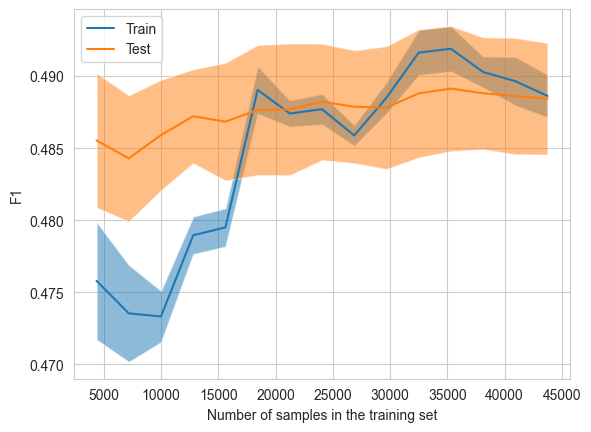

In [336]:
# log_reg.fit(transformed_array,y_train)
LearningCurveDisplay.from_estimator(
   lr_grid.best_estimator_, X_train_lin, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold, scoring='f1',n_jobs=-1)

In [337]:
lr_grid.best_params_

{'C': np.float64(166.81005372000558),
 'class_weight': 'balanced',
 'l1_ratio': 0.1,
 'penalty': 'l1',
 'solver': 'saga'}

We can see that the model struggles to identify the positive class. Only 40% of predicted clicks turn out to be actual clicks (lot's of false positives). 62% of all clicks are actually identified (lot's of false negatives). 

In [338]:
print(classification_report(y_val,lr_grid.best_estimator_.predict(X_val_lin)))

              precision    recall  f1-score   support

           0       0.91      0.71      0.79      5494
           1       0.37      0.71      0.49      1341

    accuracy                           0.71      6835
   macro avg       0.64      0.71      0.64      6835
weighted avg       0.80      0.71      0.73      6835



Looking at the PR curve we can see that it is unstable at the beginning and then eventually levels out and drops off.

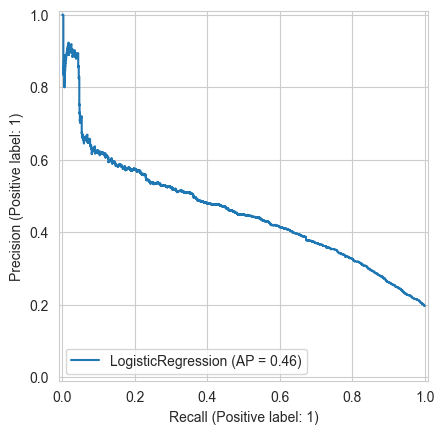

In [339]:
PrecisionRecallDisplay.from_estimator(lr_grid.best_estimator_,X_val_lin,y_val)

Also not surprising to see our two interactions have better coefficients since we know those subsets click very frequently

In [340]:
lr_grid.best_estimator_.feature_names_in_

array(['Total_Past_Communications Subject_Hotness_Score',
       'Total_Past_Communications Word_Count',
       'Word_Count Email_Campaign_Type_2',
       'Word_Count Subject_Hotness_Score', 'Total_Past_Communications',
       'Total_Past_Communications Email_Campaign_Type_2',
       'Email_Campaign_Type_2 Subject_Hotness_Score',
       'Email_Campaign_Type_2', 'Word_Count', 'Email_Campaign_Type_3',
       'Subject_Hotness_Score', 'Total_Links'], dtype=object)

In [341]:
lr_grid.best_estimator_.coef_

array([[ 0.02073606,  0.17642914, -0.46714207,  0.11691916,  0.82193045,
        -0.08018471,  0.51909397, -6.57073714, -0.02989902, -5.33974093,
         0.01530842,  0.06915597]])

## Tree Based

Let's see if we can make much improvement with the tree based models. We will take a different approach to feature engineering and selection. Instead of looking at mutual information and dropping fields beforehand, we will select features after baseline modeling based on SHAP values and feature importances so that the models have every chance to find interactions.

Quick Takeaways:

* All models have very similar performance on the baseline, of which are improvements compared to logistic regression particularly for Recall, which makes sense since we need more complex interactions to find out when people click.
* Hovering around 50% F1, with Precision ~38% and Recall 67%
* EasyEnsemble was not stable and will not be used in tuning
* SHAP values and feature importances indicate a handful of features as being worth keeping for the next phase, which will help with generalizability and complexity reduction
    * We will keep 8 fields after looking at the SHAP values in the baseline models. Random Forest shows 9 as being important but the other two don't. For simplicity of data management we will use the 8 for all three. Also, Gradient Boosting only had 6-7 that seemed important whereas XGB had 8, which may have been due to overfitting. 
        * Total_Past_Communications
        * Email_Campaign_Type_2
        * Word_Count
        * Email_Campaign_Type_3
        * Email_Campaign_Type_1
        * Total_Links
        * Subject_Hotness_Score
        * Email_Type_1


### Feature engineering and preprocessing
* Impute missing values
* Leave count data as-is (or as float for imputed values)
* OHE categoricals

* Tried binning count data but lost signal
* Perhaps a mix of binning and integer encoding would be better? Did not have time to try but would be an interesting next step.

In [88]:
# # We can make a custom transformer that allows us to specify integer-indexed bins 
# class Digitizer(BaseEstimator, TransformerMixin):
#     def __init__(self, bins):
#         self.bins = bins
    
#     def get_feature_names_out(self, X, y=None):
#         return self

#     def fit(self, X, y=None):
#         # No fitting necessary for binning
#         return self
    
#     def transform(self, X):
#         # Apply np.digitize to bin data
#         X_binned = np.digitize(X, bins=self.bins, right=False)#.reshape(-1, 1)
#         return pd.DataFrame(X_binned, index=X.index, columns=X.columns)

In [89]:
preprocessor_tree = ColumnTransformer([

    ('past_comm', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        # ('digitze', Digitizer(bins = [0,1,20,30,40,50,np.inf]))
    ]), ['Total_Past_Communications']),

    ('links', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        # ('digitze', Digitizer(bins = [1,2,5,7,10,15,20,50,np.inf]))
    ]), ['Total_Links']),  

    # ('hot', Digitizer(bins = [0,1,2,3,4,5]), ['Subject_Hotness_Score']),  

    ('images', Pipeline([
        ('impute', KNNImputer(n_neighbors=5)),
        # ('digitze', Digitizer(bins = [0,1,3,5,7,10,np.inf]))
        ]), ['Total_Images']),
        
    # ('words', Digitizer(bins = [0,100,200,300,400,500,600,700,800,900,1000,np.inf]), ['Word_Count']),

    ('location', Pipeline([
        ('impute',SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encode', OneHotEncoder(sparse_output=False))# 
        ]),['Customer_Location']),

    ('encoder', OneHotEncoder(sparse_output=False),['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type', 'Time_Email_sent_Category'])#
    
], remainder='passthrough')
# preprocessor.fit(X_train)
preprocessor_tree.set_output(transform='pandas')
X_train_tree = preprocessor_tree.fit_transform(X_train)
X_train_tree.columns = X_train_tree.columns.str.split('__').str[-1]
X_train_tree

,Total_Past_Communications,Total_Links,Total_Images,Customer_Location_A,Customer_Location_B,Customer_Location_C,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,...,Email_Source_Type_1,Email_Source_Type_2,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,Subject_Hotness_Score,Word_Count
14527,28.961641,18.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.2,700
30487,14.000000,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.5,636
21040,38.000000,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.4,778
16352,25.000000,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.2,778
15436,45.000000,21.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60625,30.000000,21.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.2,636
54805,29.000000,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,721
22595,14.000000,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.3,524
42562,28.961641,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5,694


Getting weird warnings when fitting my validation data so the below confirms the pipeline is in fact fitted.

In [90]:
from sklearn.utils.validation import check_is_fitted
print(check_is_fitted(preprocessor_tree))

None


In [91]:
X_val_tree = preprocessor_tree.transform(X_val)
X_val_tree.columns = X_val_tree.columns.str.split('__').str[-1]
X_val_tree

,Total_Past_Communications,Total_Links,Total_Images,Customer_Location_A,Customer_Location_B,Customer_Location_C,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,...,Email_Source_Type_1,Email_Source_Type_2,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,Subject_Hotness_Score,Word_Count
51499,19.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.8,868
6711,42.000000,4.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.3,275
33544,28.000000,16.000000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,806
64771,25.000000,9.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.2,251
12820,30.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.2,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39140,42.000000,8.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.4,424
26902,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.3,704
16423,40.000000,21.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.1,79
33690,23.000000,10.415064,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.5,490


### Random Forest

The baseline random forest does pretty decently. We can already get a feel for how to tune it, using less deep trees and focusing on splits and leaves for optimization. We also will always use balanced weight classes due to the imbalance between clicks/no clicks.

Takeaways from baseline random forest:
* Very stable compared to logistic regression
* Improvement in F1, which is our target metric (50% F1, 66% Recall, 41% Precision)
* Some overfitting but we can tune this later
* PR curve showing tradeoff in favor of precision until recall hits about 20% then we can make gains without trading off precision much for the rest of the thresholds. Very linear descent.
* Important features include
    * Tier 1
        * Total_Past_Communications
        * Email_Campaign_Type_2
        * Word_Count
        * Email_Campaign_Type_3
        * Subject_Hotness_Score
    * Tier 2
        * Email_Campaign_Type_1
        * Total_Links
        * Email_Type_2
        * Email_Type_1
        * Total_Images


In [92]:
from sklearn.ensemble import RandomForestClassifier
import shap
# reinstantiate k fold for convenience. no change made.
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [711]:
ran_for = RandomForestClassifier(class_weight='balanced',max_depth=10,random_state=seed)

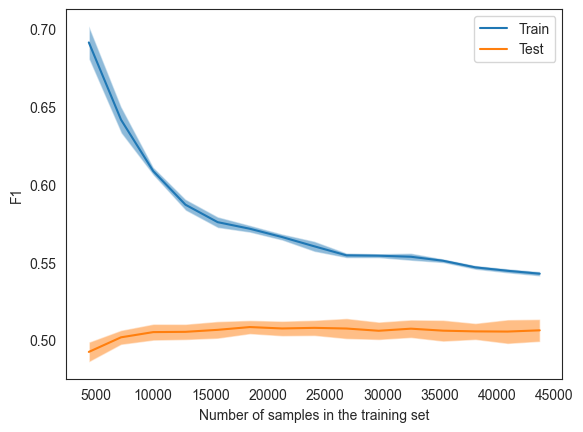

In [712]:
LearningCurveDisplay.from_estimator(
   ran_for, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold, scoring = 'f1',n_jobs=-1)

In [713]:
ran_for.fit(X_train_tree,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=23)

In [714]:
print(classification_report(y_val,ran_for.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      5494
           1       0.41      0.65      0.50      1341

    accuracy                           0.74      6835
   macro avg       0.65      0.71      0.66      6835
weighted avg       0.80      0.74      0.76      6835



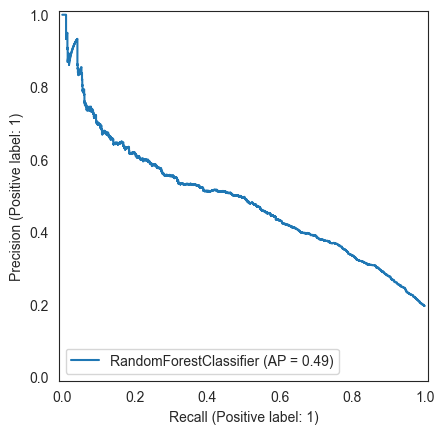

In [715]:
PrecisionRecallDisplay.from_estimator(ran_for,X_val_tree,y_val)

In [716]:
importances_df = pd.DataFrame({
    'Importance': ran_for.feature_importances_,
    'Feature': X_val_tree.columns  # Use original column names from X_val_tree
})

# Display the DataFrame with feature importances and original feature names
importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importances_df

,Importance,Feature
0,0.244193,Total_Past_Communications
1,0.186010,Word_Count
2,0.168156,Email_Campaign_Type_2
3,0.105758,Email_Campaign_Type_3
4,0.080834,Subject_Hotness_Score
5,0.068830,Total_Links
6,0.030128,Email_Campaign_Type_1
7,0.025924,Total_Images
8,0.021490,Email_Type_2
9,0.017135,Email_Type_1


A much more effective way to understand feature impact is SHAP values. This will indicate exactly how much each feature contributed to the prediction down to the level of the record. Here we see a slightly different order but all-in-all the same.

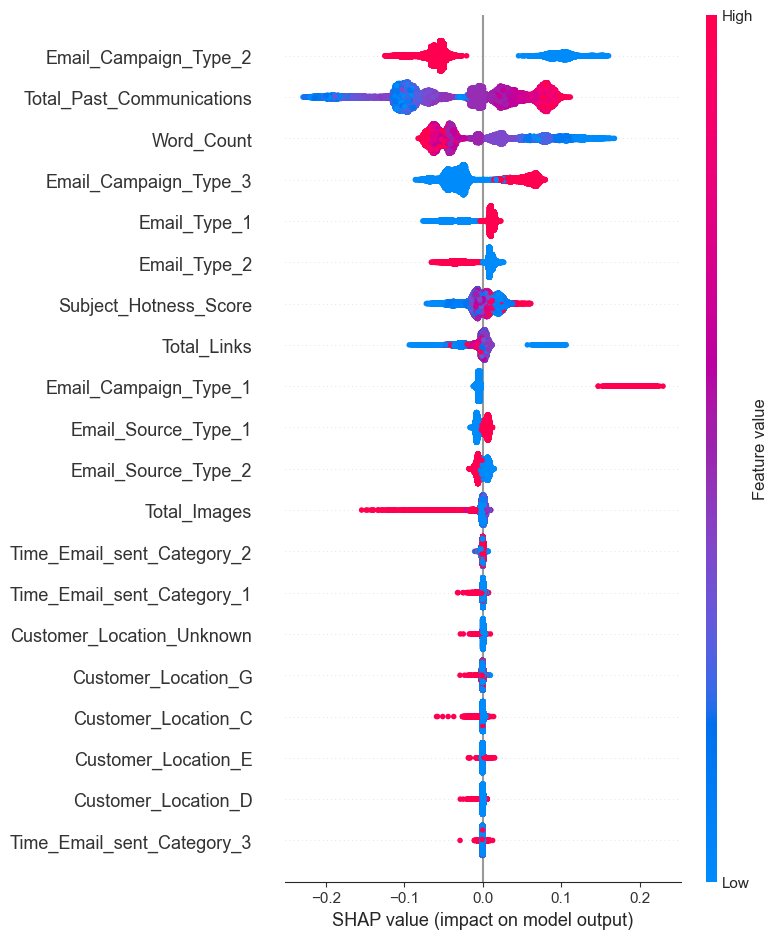

In [694]:
explainer = shap.TreeExplainer(ran_for)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps[:, :, 1], X_train_tree)

### EasyEnsemble AdaBoost

We can try a different algorithm coming from a library whose design is to handle class imbalance for you with resampling techniques happening under the hood. EasyEnsemble does this plus it uses AdaBoosting classifiers from SKLearn to build the model. Though tree-based, this is a very different way to learn compared to a random forest.

Notes: 
* Take a along time to run but has similar metrics to Random Forest
* More unstable model compared to RF since learning curves are eratic and variable
* We will not take this to tuning as the other models should suffice and run faster
* PR curve less smooth, big drop at higher thresholds

In [695]:
from imblearn.ensemble import EasyEnsembleClassifier

Also has concerning learning curves, like logistic regression. Likely isn't picking up on patterns with the weak learners.

In [ ]:
easy = EasyEnsembleClassifier(n_estimators=100)
LearningCurveDisplay.from_estimator(
   easy, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold, scoring = 'f1', n_jobs=-1,random_state=seed)

In [ ]:
easy.fit(X_train_tree,y_train)

This weak learner has a steeper drop off for those earlier probabilities, but does stabilize. Due to how long it takes to train we won't pursue this more.

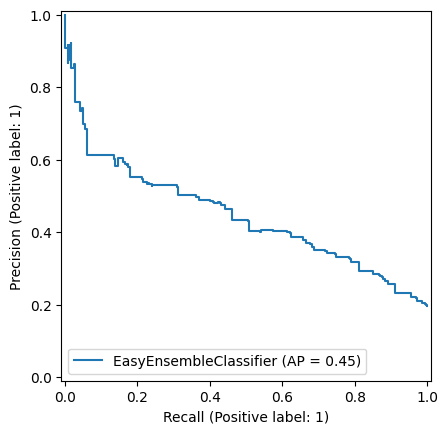

In [ ]:
PrecisionRecallDisplay.from_estimator(easy,X_val_tree,y_val)

In [ ]:
print(classification_report(y_val,easy.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      5494
           1       0.37      0.67      0.48      1341

    accuracy                           0.71      6835
   macro avg       0.64      0.70      0.64      6835
weighted avg       0.80      0.71      0.74      6835



### Gradient Boosting

We can try a different tree-based learning method called Gradient Boosting. This will fit successive models, each on the errors of the previous model, with the intent to learn from past mistakes. We will use sklearn's implementation of histogram gradient boosting, which is similar to `LightGBM`, and is known to be both fast and high performing.

* Notes:
    * More stable than Random Forests, similar performance with metrics though
    * Improvement particularly with Recall compared to RF. 67% --> 70%.
    * Precision improves by 1% to 39%
    * PR curve shows less drop off at higher thresholds indicating it is able to pick up on our target class better
    * SHAP showing the following important features. Interesting note here is that we lost Campaign_Type_3 whereas RF had it as an important feature. Campaign_Type_1 is definitely the least important of the 7 but it likely is helpful for interactions since so many in this Campaign click, so we can keep it.
        * Email_Campaign_Type_2
        * Total_Past_Communications
        * Word_Count
        * Email_Type_1
        * Sugject_Hotness_Score
        * Total_Links
        * Campaign_Type_1

In [120]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [718]:
hist_gradboost = HistGradientBoostingClassifier(max_depth=10,class_weight='balanced',random_state=seed)

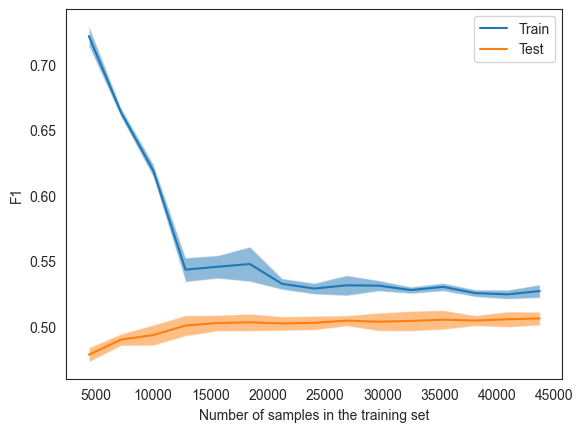

In [719]:
LearningCurveDisplay.from_estimator(
   hist_gradboost, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold,scoring = 'f1' ,n_jobs=-1, random_state=seed)#score_name="Expected Profit per Email"

In [720]:
hist_gradboost.fit(X_train_tree,y_train)
print(classification_report(y_val,hist_gradboost.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      5494
           1       0.40      0.70      0.51      1341

    accuracy                           0.73      6835
   macro avg       0.65      0.72      0.66      6835
weighted avg       0.81      0.73      0.76      6835



We can see how on the PR curve there is not nearly as much of a drop off for lower probability thresholds, which shows that improvement in recall since it is sustained across the later thresholds.

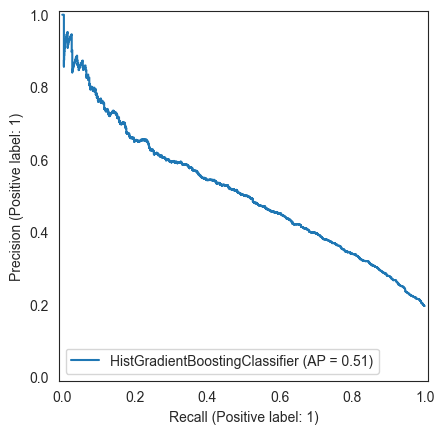

In [721]:
PrecisionRecallDisplay.from_estimator(hist_gradboost,X_val_tree,y_val)

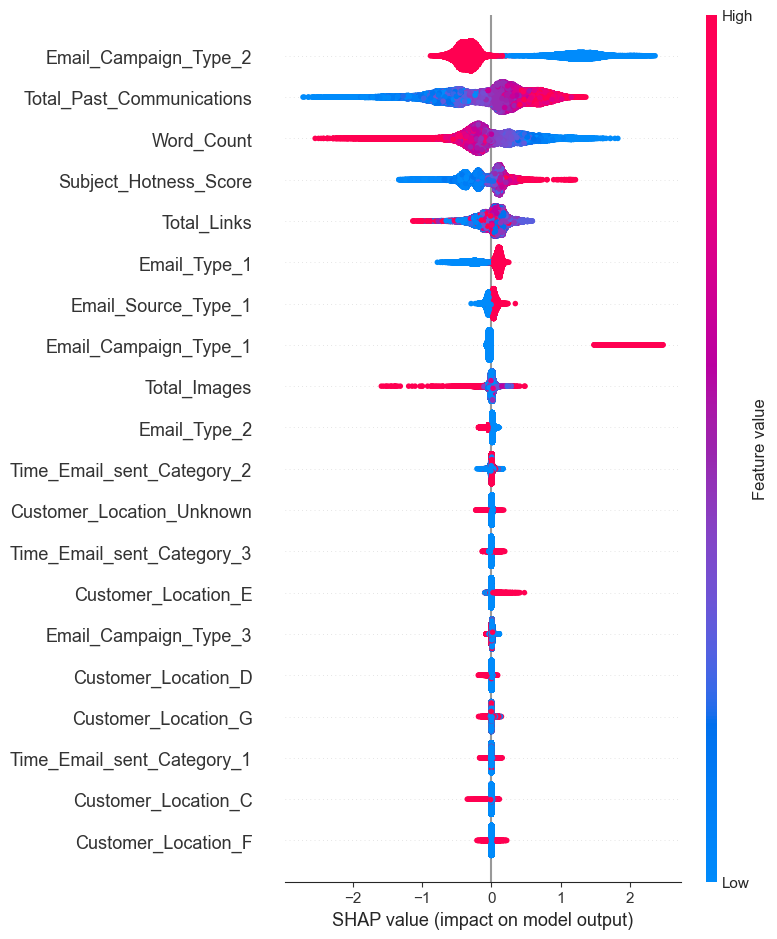

In [722]:
explainer = shap.TreeExplainer(hist_gradboost)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps,X_train_tree)

### XGBoost

Ol' reliable. XGBoost is also a gradient boosting algorithm, like HistGradientBoost, but it is a lot more than that. It has a lot going on under the hood that allow it to be pretty regularly the highest performing ML algorithm particularly for structured data, which tree-based models thrive with.

* Notes:
    * Baseline model only uses the ratio of the classes as the weight
    * Initial results show similar performance as the other algorithms, with more overfitting but overall stability with little variance in predictions
    * Slightly down on Recall but tuning should bring it up pretty quickly. The question is how far up? Same for Precision.
    * SHAP values show the power of XGBoost where even the least important features have significantly more importance. A lot of this is due to overfitting though, so we can expect that to drop during tuning. We see the same 8 again, so we will keep only them.

In [121]:
import xgboost as xgb

In [728]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = 81/19,objective= 'binary:logistic',eval_metric='logloss', random_state=seed)

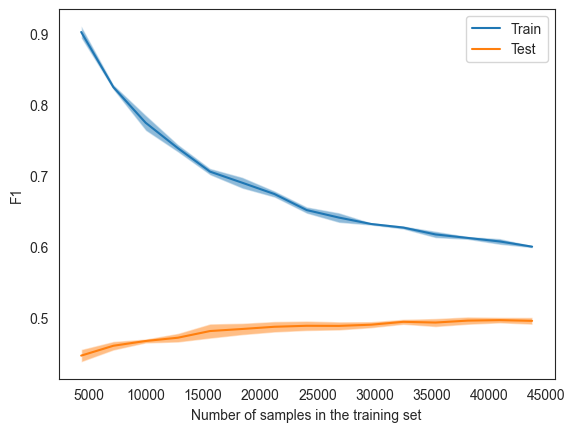

In [729]:
LearningCurveDisplay.from_estimator(
   xgb_model, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold,scoring = 'f1',n_jobs=-1, random_state=seed)

In [730]:
xgb_model.fit(X_train_tree,y_train)
print(classification_report(y_val,xgb_model.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      5494
           1       0.39      0.69      0.50      1341

    accuracy                           0.73      6835
   macro avg       0.65      0.72      0.66      6835
weighted avg       0.81      0.73      0.75      6835



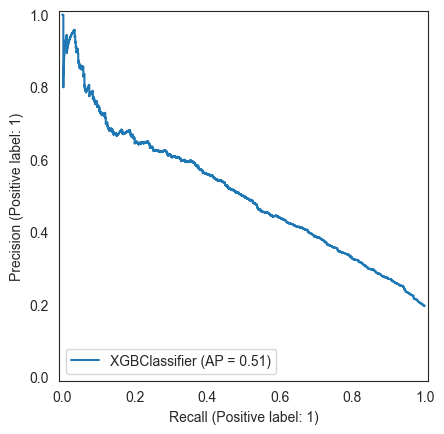

In [731]:
PrecisionRecallDisplay.from_estimator(xgb_model,X_val_tree,y_val)

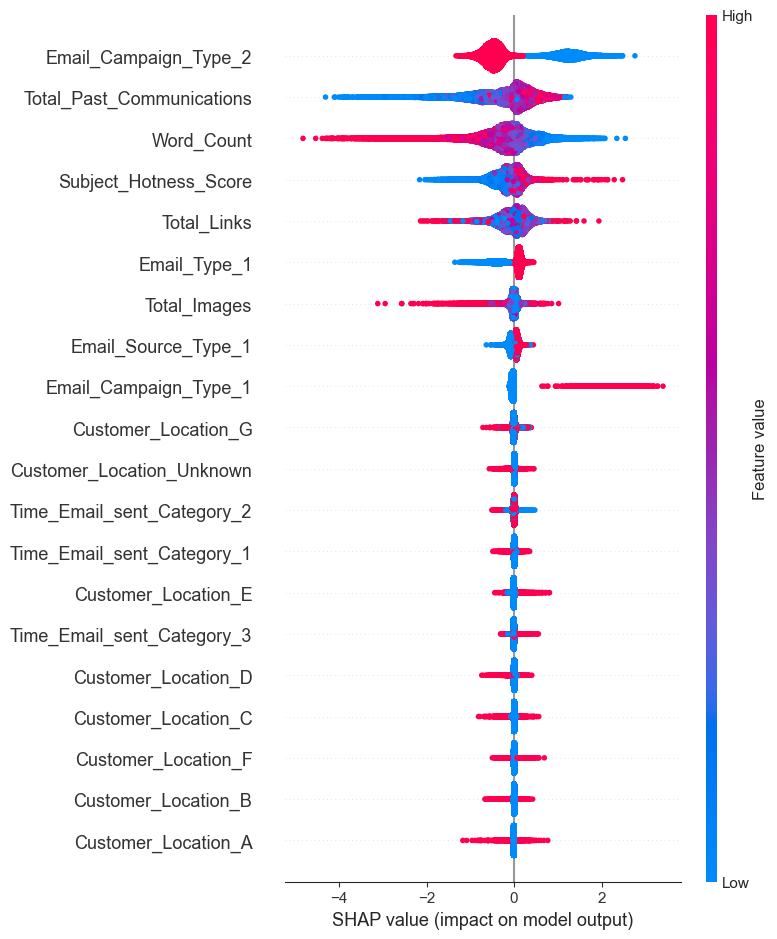

In [732]:
explainer = shap.TreeExplainer(xgb_model)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps,X_train_tree)

# Hyperparameter Tuning

We will now try to improve upon our most promising baselinem odels with the reduced feature set. We will do so using RandomSearchCV to explore hyperparamater spaces. We can use our validation data to iterate to improve upon the search grid. Once we have optimized each model, we will calibrate the probabilities so that we can choose the proper decision threshold. To choose the threshold, we will use a custom scorer which is what will optimize the profit margin. My proposal to the business will be whichever model is the best combo of 1) profitable, 2) stable, and 3) simple.

In [93]:
tree_features = [
'Total_Past_Communications'
,'Email_Campaign_Type_2'
,'Word_Count'
,'Email_Campaign_Type_3'
,'Email_Campaign_Type_1'
,'Total_Links'
,'Subject_Hotness_Score'
,'Email_Type_1'
,'Total_Images'
]

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

X_train_tree = X_train_tree[tree_features].copy()
X_val_tree = X_val_tree[tree_features]

The following scorer is what we will use to determine the correct probability threshold for each model post-calibration. It calculates the Expected Value per Email sent (profit margin). For the sake of discussion I've made up revenue and cost amounts per click and email that we can use to see what a profit optimization problem would look like.

We will assume that one click makes us $0.75 and one email costs $0.15 to send.

Let

$$TP = True Positives$$
$$FP = False Positives$$
$$ TP+FP = All Predicted Clicks$$
$$C_{email} = Cost per Email$$
$$R_{Click} = Revenue per Click$$

$$EV = \frac{(TP \times R_{click}) - ((TP + FP) \times C_{email})}{Count_{Emails}}$$

In [229]:
# from sklearn.metrics import make_scorer
def expected_value(y_true, y_pred_proba, threshold, R_click=0.75, C_email=.15):
    y_pred = (y_pred_proba >= threshold).astype(int) 
    
    TP = np.sum((y_pred == 1) & (y_true == 1)) 
    FP = np.sum((y_pred == 1) & (y_true == 0))  
    
    # Expected value equation
    EV = ((TP * R_click) - ((TP + FP) * C_email)) / len(y_true)
    return EV

def ev_scorer(y_true, y_pred_proba,threshold):
            return expected_value(y_true, y_pred_proba, threshold)

# ev = make_scorer(ev_scorer, response_method='predict_proba')

The following function will iterate through probability thresholds to show where the profit is maximized and we will choose that as our decision threshold. We will then choose the model with the highest profit margin. If there are ties then we can opt for the more stable model. If they are similarly stable then we default to the simpler model due to the principle of parsimony.

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def ev_per_email(model, X, Y, model_name):
    ev_list = []
    thresh_list = np.linspace(0, 0.9, 100)  # More resolution in threshold steps

    for i in thresh_list:
        y_pred = model.predict_proba(X)[:, 1]
        score = ev_scorer(Y, y_pred, i)
        ev_list.append(score)
        # print(score)

    # Find max value and corresponding threshold
    max_ev = max(ev_list)
    max_thresh = thresh_list[np.argmax(ev_list)]
    
    # Set presentation-friendly style
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot line
    sns.lineplot(x=thresh_list, y=ev_list, linewidth=2.5, color="royalblue")

    # Highlight max point
    plt.axhline(y=max_ev, color='red', linestyle='dashed', linewidth=1.5)
    plt.axvline(x=max_thresh, color='red', linestyle='dashed', linewidth=1.5)
    plt.scatter(max_thresh, max_ev, color='red', s=100, zorder=3)

    # Annotate max point
    plt.annotate(f'Max: {max_ev:.3f} at {max_thresh:.2f}', 
                 xy=(max_thresh, max_ev), 
                 xytext=(max_thresh + 0.05, max_ev - 0.02), 
                 arrowprops=dict(facecolor='red', arrowstyle="->"),
                 fontsize=12, fontweight='bold', color='red')

    # Labels and title
    plt.xlabel('Decision Threshold', fontsize=14, fontweight='bold')
    plt.ylabel('Expected Profit per Email', fontsize=14, fontweight='bold')
    plt.title(f"Expected Profit per Email Sent - {model_name}", fontsize=16, fontweight='bold')

    # Show plot
    plt.show()
    return ev_list

### Logistic Regression

In [342]:
cal_lr = CalibratedClassifierCV(FrozenEstimator(lr_grid.best_estimator_))
cal_lr.fit(X_train_lin,y_train)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=LogisticRegression(C=np.float64(166.81005372000558),
                                                                              class_weight='balanced',
                                                                              l1_ratio=0.1,
                                                                              max_iter=5000,
                                                                              n_jobs=-1,
                                                                              penalty='l1',
                                                                              random_state=23,
                                                                              solver='saga')))

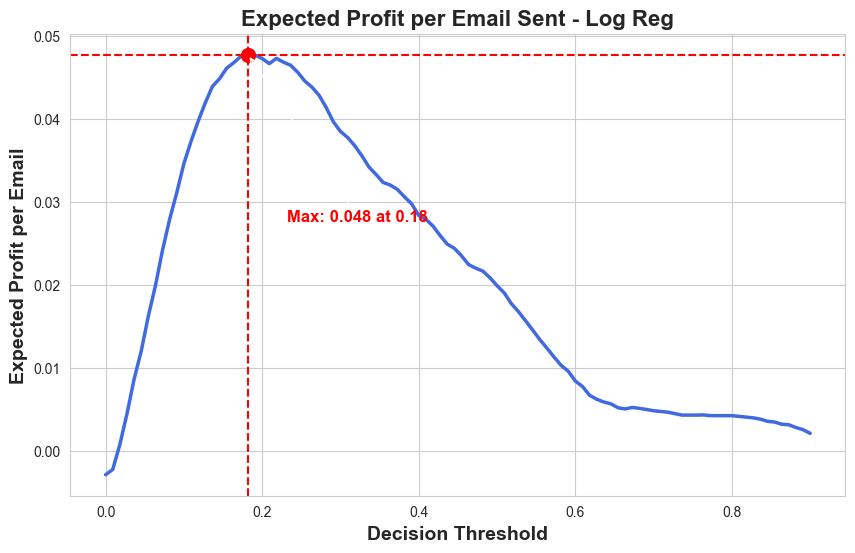

[np.float64(-0.0028529626920263352),
 np.float64(-0.0022165325530358417),
 np.float64(0.0007900512070226907),
 np.float64(0.004476956839795175),
 np.float64(0.008646671543525972),
 np.float64(0.012026335040234096),
 np.float64(0.01623994147768837),
 np.float64(0.019904901243599133),
 np.float64(0.024206291148500373),
 np.float64(0.027915142648134612),
 np.float64(0.0311192392099488),
 np.float64(0.03460863204096563),
 np.float64(0.03728602779809803),
 np.float64(0.039700073152889544),
 np.float64(0.04191660570592538),
 np.float64(0.043891733723482075),
 np.float64(0.044813460131675205),
 np.float64(0.046086320409656184),
 np.float64(0.046744696415508415),
 np.float64(0.04751280175566935),
 np.float64(0.04771031455742502),
 np.float64(0.04766642282370154),
 np.float64(0.047249451353328455),
 np.float64(0.046634967081199706),
 np.float64(0.0472713972201902),
 np.float64(0.046810534016093634),
 np.float64(0.04643745427944404),
 np.float64(0.04558156547183614),
 np.float64(0.04452816386247

In [343]:
ev_per_email(cal_lr, X_val_lin, y_val, "Log Reg")

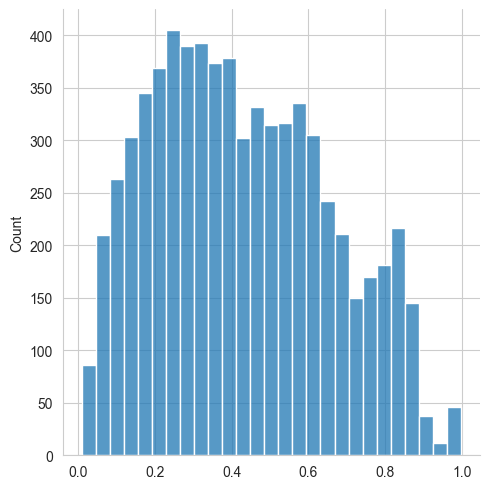

In [344]:
sns.displot(lr_grid.best_estimator_.predict_proba(X_val_lin)[:, 1])

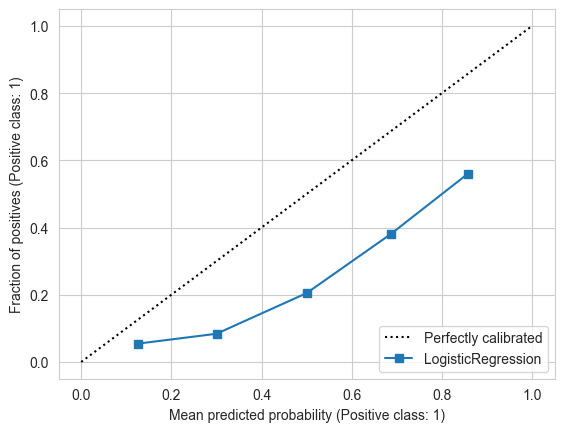

In [345]:
CalibrationDisplay.from_estimator(lr_grid.best_estimator_,X_val_lin,y_val)

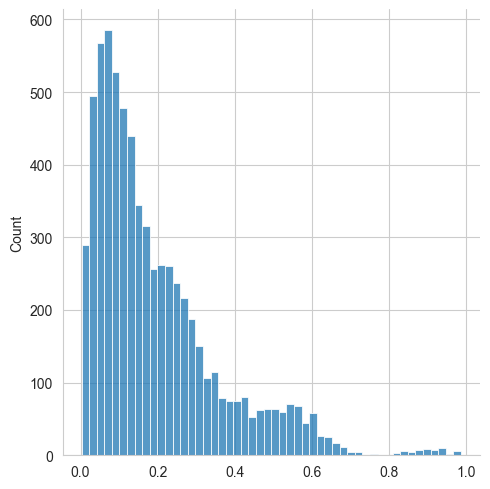

In [346]:
sns.displot(cal_lr.predict_proba(X_val_lin)[:, 1])

In [347]:
lr_thresh = .18
cal_y = (cal_lr.predict_proba(X_val_lin)[:,1] >= lr_thresh)#.astype(int)
print(classification_report(y_val,cal_y))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      5494
           1       0.36      0.74      0.48      1341

    accuracy                           0.69      6835
   macro avg       0.63      0.71      0.63      6835
weighted avg       0.80      0.69      0.72      6835



### Dummy Model

In [97]:
from sklearn.dummy import DummyClassifier

In [98]:
dumb = DummyClassifier(strategy='stratified', random_state=seed)
dumb.fit(X_train_tree,y_train)

DummyClassifier(random_state=23, strategy='stratified')

The baseline by just guessing based on the 81/19 class split would result in basically breaking even

In [99]:
round(ev_scorer(y_val,dumb.predict_proba(X_val)[:,1],.2),3)

np.float64(-0.001)

In [100]:
print(classification_report(y_val,dumb.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      5494
           1       0.19      0.19      0.19      1341

    accuracy                           0.68      6835
   macro avg       0.50      0.50      0.50      6835
weighted avg       0.68      0.68      0.68      6835



### Random Forest

After tuning the Random Forest with the reduced subset of features we do observe less stability, but also less overfitting, and higher performance. 

* Trees are only sensitive to depth and the number of leaves. Which tells me that only a few features really move the needle, since it only needs a few splits to generalize quickly.
    * Improve upon baseline by limiting depth and leaving the rest as defaults. Depth of 7 is optimial combo of variance reduction and overfitting reduction
    * Improved performance for Recall from 65% to 68%, slight drop in Precision from 41% to 40%, but less overfitting. So, a reasonable trade off though i wouldn't describe it as very stable yet since error bands are wide
* Overconfidence in the base model causes us to calibrate probabilities, and then tune the threshold with our profit optimizer.
    * Profit is optimized at 17% probability threshold, where we expect a $.05 profit per email sent
    * At this threshold we get a precision of 38% and a Recall of 72%, maintaining the 50% F1

In [ ]:
param_grid = {
    "n_estimators": [100,200,300],
    "max_depth": [7,8,9,10],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [1,2,3,5,10],
    # "max_leaf_nodes": [None, 1000]
}

In [ ]:
ran_for = RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=seed)
rf_grid = RandomizedSearchCV(n_iter=150,estimator=ran_for,param_distributions=param_grid,scoring='f1',n_jobs=-1,cv=k_fold,verbose=2, random_state=seed)
rf_grid.fit(X_train_tree,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END max_depth=8, min_samples_leaf=15, min_samples_split=5, n_estimators=200; total time=   5.5s
[CV] END max_depth=8, min_samples_leaf=15, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END max_depth=8, min_samples_leaf=15, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=8, min_samples_leaf=15, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=8, min_samples_leaf=15, min_samples_split=5, n_estimators=200; total time=   6.0s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   6.1s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   6.1s
[CV] END max_depth=9, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   6.4s
[CV] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   4.1s
[CV] END max_depth=15, min_sam

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=23),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'max_depth': [7, 8, 9, 10, 15],
                                        'min_samples_leaf': [1, 2, 3, 5, 10,
                                                             15],
                                        'min_samples_split': [2, 3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=23, scoring='f1', verbose=2)

In [746]:
rf_grid.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}

In [115]:
rf_grid = RandomForestClassifier(max_depth=7, n_estimators=100, max_leaf_nodes=60, min_samples_leaf=1, min_samples_split=2, n_jobs=-1, class_weight='balanced', random_state=seed)
rf_grid.fit(X_train_tree, y_train)
print(classification_report(y_val, rf_grid.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      5494
           1       0.40      0.68      0.50      1341

    accuracy                           0.73      6835
   macro avg       0.65      0.71      0.66      6835
weighted avg       0.81      0.73      0.76      6835



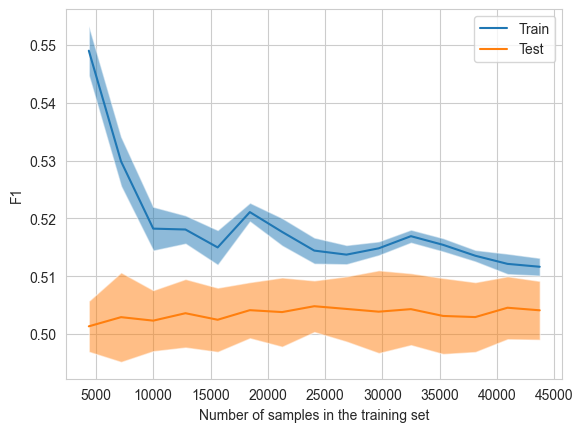

In [908]:
LearningCurveDisplay.from_estimator(
   rf_grid, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold, scoring = 'f1', n_jobs=-1, random_state=seed)

In [1098]:
importances_df = pd.DataFrame({
    'Importance': rf_grid.feature_importances_,
    'Feature': X_val_tree.columns  # Use original column names from X_val_tree
})

# Display the DataFrame with feature importances and original feature names
importances_df.sort_values(by='Importance', ascending=False)

,Importance,Feature
0,0.303447,Total_Past_Communications
2,0.194300,Word_Count
1,0.192215,Email_Campaign_Type_2
3,0.112618,Email_Campaign_Type_3
6,0.079698,Subject_Hotness_Score
4,0.045570,Email_Campaign_Type_1
7,0.032071,Email_Type_1
5,0.031863,Total_Links
8,0.008217,Total_Images


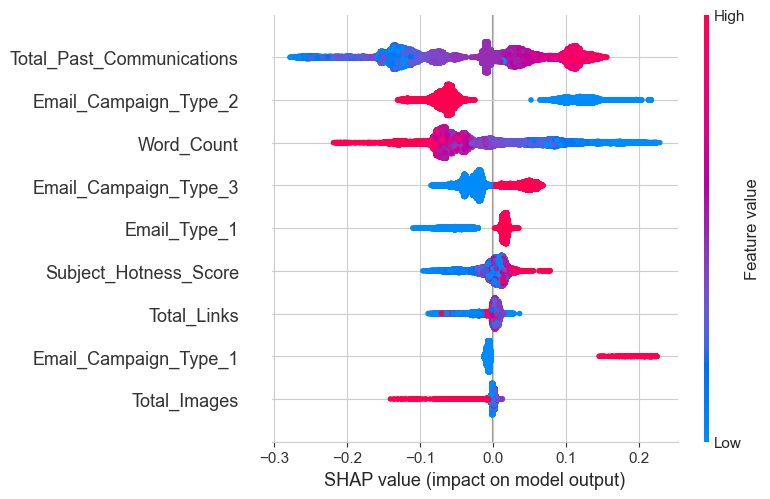

In [1099]:
explainer = shap.TreeExplainer(rf_grid)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps[:, :, 1], X_train_tree)

We can see from the distribution of probabilities along with the calibration curve that we need to do some post-tuning. Tree based models are notorious for being over confident.

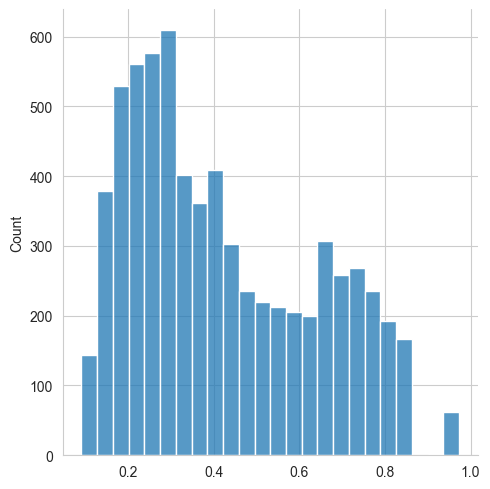

In [1100]:
sns.displot(rf_grid.predict_proba(X_val_tree)[:, 1])

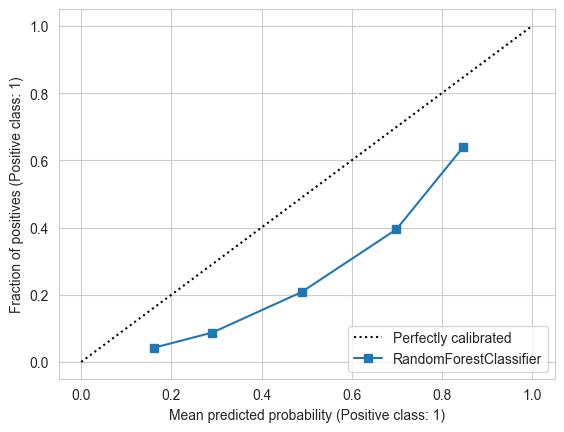

In [1101]:
CalibrationDisplay.from_estimator(rf_grid,X_val_tree,y_val)

In [116]:
cal_rf = CalibratedClassifierCV(FrozenEstimator(rf_grid))
cal_rf.fit(X_train_tree,y_train)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                  max_depth=7,
                                                                                  max_leaf_nodes=60,
                                                                                  n_jobs=-1,
                                                                                  random_state=23)))

Unsurprisingly, our probability distribution is skewed. What we can do is look at a PR curve and determine what threshold here makes sense to use in order to get to a better recall without having to trade off too much precision. It will be less than optimal, but if we can get jumps in recall without f1 dropping more than a few % then this is a win.

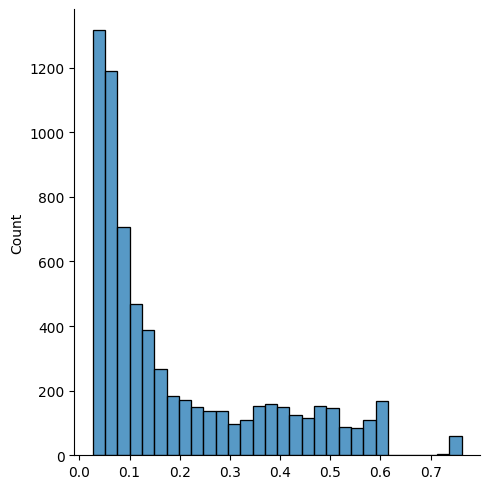

In [103]:
sns.displot((cal_rf.predict_proba(X_val_tree))[:,1])

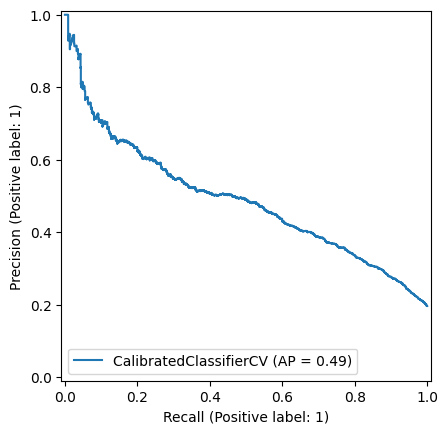

In [104]:
PrecisionRecallDisplay.from_estimator(cal_rf,X_val_tree,y_val)

For a random forest we will use 17% as our probability threshold. Here we would make about $.05 per Email sent 

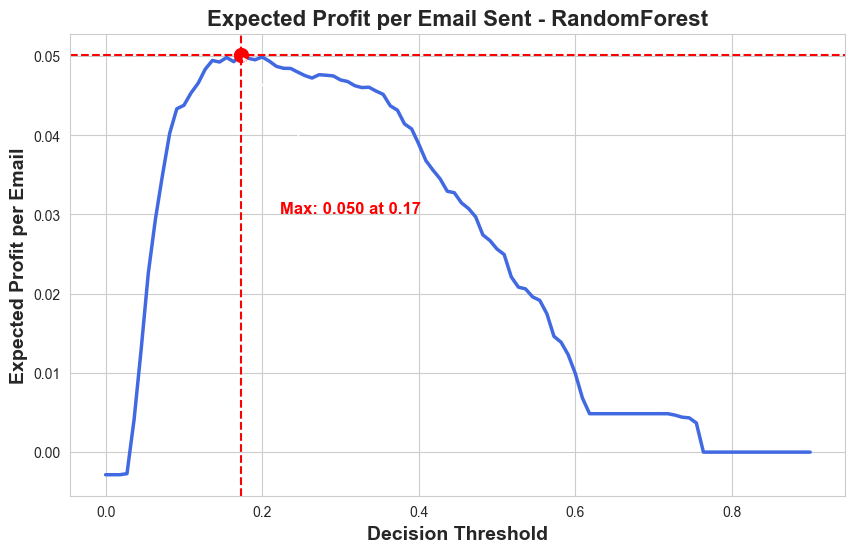

[np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0027212874908558757),
 np.float64(0.004125822970007322),
 np.float64(0.01303584491587418),
 np.float64(0.02262618873445501),
 np.float64(0.02942940746159473),
 np.float64(0.035025603511338696),
 np.float64(0.040248719824433066),
 np.float64(0.04334308705193855),
 np.float64(0.04378200438917337),
 np.float64(0.04534016093635698),
 np.float64(0.046569129480614486),
 np.float64(0.04834674469641551),
 np.float64(0.04944403803950256),
 np.float64(0.04924652523774689),
 np.float64(0.04981711777615216),
 np.float64(0.04929041697147038),
 np.float64(0.05016825164594002),
 np.float64(0.049707388441843456),
 np.float64(0.04953182150694953),
 np.float64(0.04988295537673738),
 np.float64(0.0493562545720556),
 np.float64(0.04869787856620337),
 np.float64(0.048456474030724214),
 np.float64(0.04843452816386248),
 np.float64(0.04797366495976592),
 np.float64(0.0475347476225311)

In [117]:
ev_per_email(cal_rf, X_val_tree, y_val, "RandomForest")

In [118]:
rf_thresh = .17
cal_y = (cal_rf.predict_proba(X_val_tree)[:,1] >= rf_thresh)#.astype(int)
print(classification_report(y_val,cal_y))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      5494
           1       0.38      0.72      0.50      1341

    accuracy                           0.71      6835
   macro avg       0.65      0.72      0.65      6835
weighted avg       0.81      0.71      0.74      6835



### Hist Gradient Boosting

HGB ends up having a similar profit optimization as random forest but it gets there very differently. 

* HGB requires even fewer trees. Here we again make it a skinnier forest by limit leaf volume. Moderate L2 regularization, moderate learning rate. Little overfitting and fast convergence.
* Kept F1 high, only traded off precision by 1% to get a better fit.
* The optimal threshold is at 18%, compared to 17% for the random forest, and it improved recall (68% vs 70%) but traded off precision (39% vs 40%), resulting in a higher F1 
    * EV optimized at .051 which is an improvement compared to RF as well. At this level we observe Recall at 73% and precision at 38% so a pretty solid tradeoff

In [136]:
hgb_gclf = HistGradientBoostingClassifier(class_weight='balanced', scoring='f1', random_state=seed)

In [138]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.3],  # Controls step size; 0.1 is default.
    "max_iter": [200, 300, 500],  # Number of boosting iterations.
    "max_leaf_nodes": [15, 31, 63, 127, 200],  # Controls tree complexity; 31 is default.
    "max_depth": [None, 7, 10, 15],  # Limits tree depth.
    "min_samples_leaf": [2, 5, 7],  # Minimum samples per leaf.
    "l2_regularization": [0, .1, 1, 10],  # Controls regularization strength.
    "early_stopping": [True],  # Enables early stopping.
    # "scoring": ['recall','f1']
    
}

In [ ]:
hgb_grid = RandomizedSearchCV(n_iter=250,estimator=hgb_gclf,param_distributions=param_grid,n_jobs=-1,cv=k_fold,verbose=2, random_state=seed, scoring='f1')
hgb_grid.fit(X_train_tree,y_train)

In [145]:
hgb_grid.best_params_

{'min_samples_leaf': 7,
 'max_leaf_nodes': 31,
 'max_iter': 200,
 'max_depth': 15,
 'learning_rate': 0.01,
 'l2_regularization': 10,
 'early_stopping': True}

In [122]:
hgb_grid = HistGradientBoostingClassifier(max_leaf_nodes=20, max_depth=5, max_iter=200, learning_rate=.3, l2_regularization=1,class_weight='balanced',
                                          random_state=seed, scoring='f1')
hgb_grid.fit(X_train_tree,y_train)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=1,
                               learning_rate=0.3, max_depth=5, max_iter=200,
                               max_leaf_nodes=20, random_state=23,
                               scoring='f1')

In [123]:
print(classification_report(y_val,hgb_grid.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      5494
           1       0.39      0.70      0.51      1341

    accuracy                           0.73      6835
   macro avg       0.65      0.72      0.66      6835
weighted avg       0.81      0.73      0.75      6835



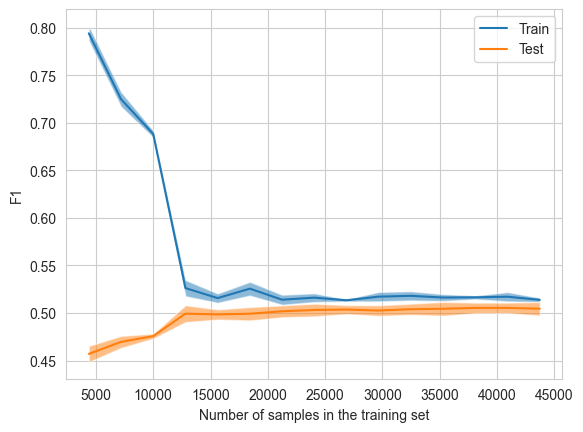

In [953]:
LearningCurveDisplay.from_estimator(
   hgb_grid, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold,scoring = 'f1' ,n_jobs=-1, random_state=seed)#score_name="Expected Profit per Email"

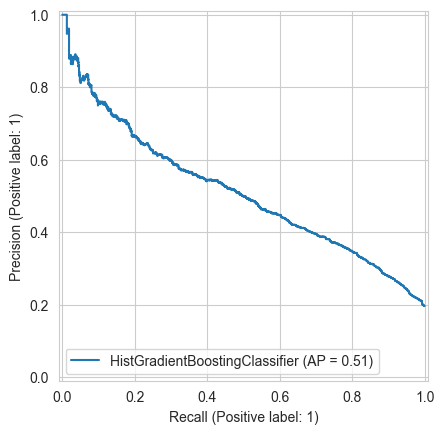

In [1109]:
PrecisionRecallDisplay.from_estimator(hgb_grid,X_val_tree,y_val)

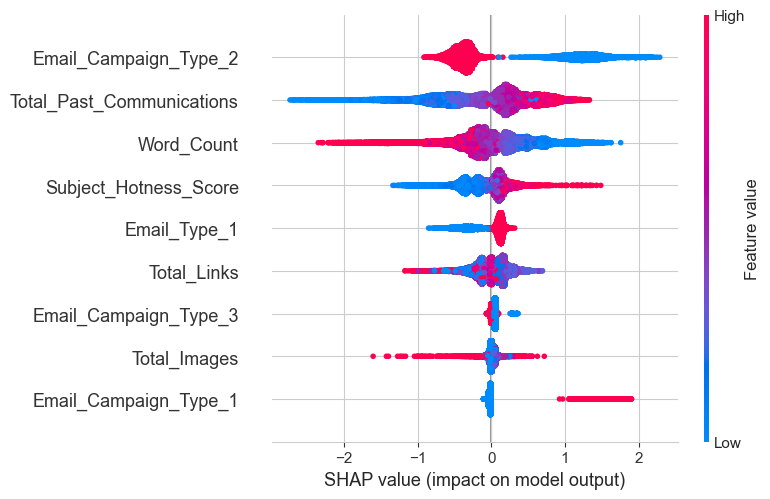

In [1110]:
explainer = shap.TreeExplainer(hgb_grid)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps, X_train_tree)

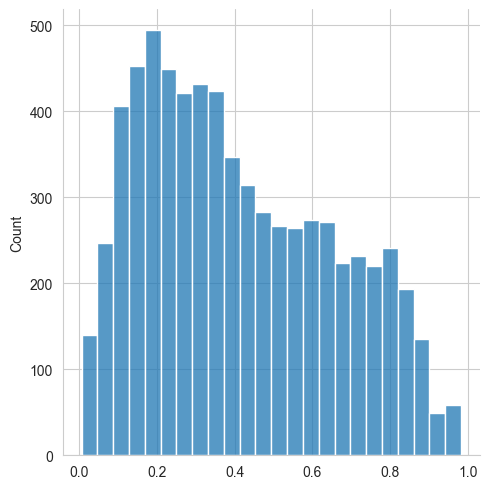

In [1111]:
sns.displot(hgb_grid.predict_proba(X_val_tree)[:, 1])

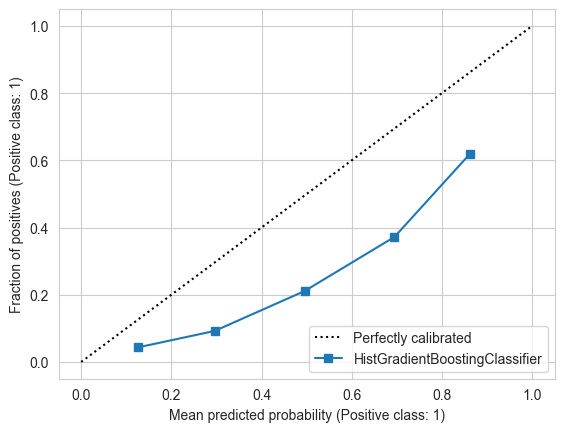

In [1112]:
CalibrationDisplay.from_estimator(hgb_grid,X_val_tree,y_val)

In [124]:
cal_hgb = CalibratedClassifierCV(FrozenEstimator(hgb_grid))
cal_hgb.fit(X_train_tree,y_train)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                                          l2_regularization=1,
                                                                                          learning_rate=0.3,
                                                                                          max_depth=5,
                                                                                          max_iter=200,
                                                                                          max_leaf_nodes=20,
                                                                                          random_state=23,
                                                                                          scoring='f1')))

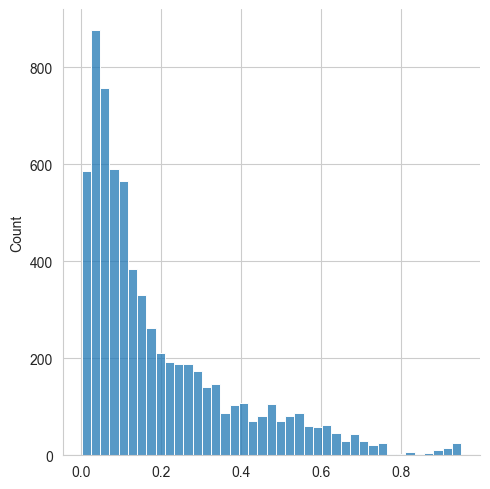

In [1114]:
sns.displot(cal_hgb.predict_proba(X_val_tree)[:, 1])

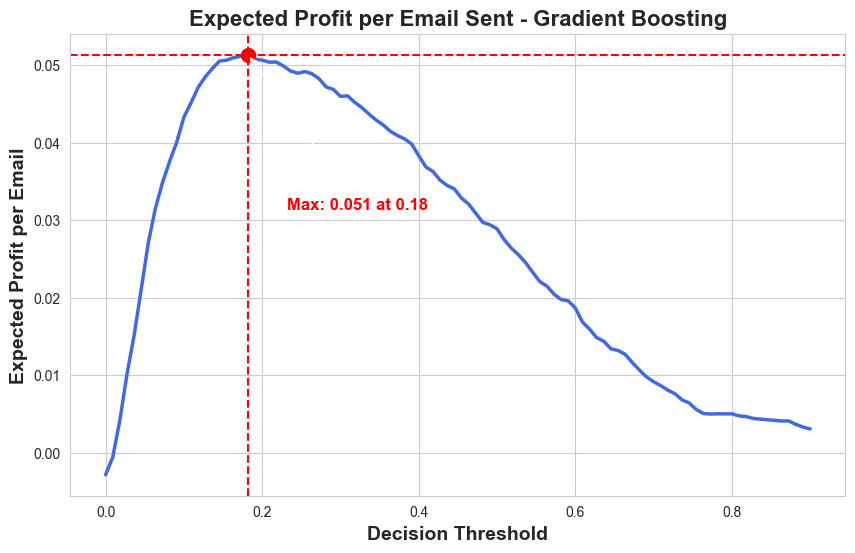

[np.float64(-0.0028529626920263352),
 np.float64(-0.0005925384052670014),
 np.float64(0.004169714703730797),
 np.float64(0.010117044623262616),
 np.float64(0.015120702267739579),
 np.float64(0.021068032187271397),
 np.float64(0.027103145574250184),
 np.float64(0.03155815654718362),
 np.float64(0.03487198244330651),
 np.float64(0.037593269934162406),
 np.float64(0.04009509875640089),
 np.float64(0.04329919531821508),
 np.float64(0.045142648134601324),
 np.float64(0.04713972201901976),
 np.float64(0.048500365764447696),
 np.float64(0.04957571324067301),
 np.float64(0.05054133138258961),
 np.float64(0.050651060716898316),
 np.float64(0.05098024871982443),
 np.float64(0.05115581565471836),
 np.float64(0.05135332845647403),
 np.float64(0.05078273591806877),
 np.float64(0.050651060716898316),
 np.float64(0.05038771031455743),
 np.float64(0.05040965618141917),
 np.float64(0.04988295537673738),
 np.float64(0.04924652523774689),
 np.float64(0.04896122896854426),
 np.float64(0.04918068763716167)

In [125]:
ev_per_email(cal_hgb, X_val_tree, y_val, "Gradient Boosting")

In [126]:
hgb_thresh = .18
cal_y = (cal_hgb.predict_proba(X_val_tree)[:,1] >= hgb_thresh)#.astype(int)
print(classification_report(y_val,cal_y))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      5494
           1       0.38      0.73      0.50      1341

    accuracy                           0.72      6835
   macro avg       0.65      0.72      0.65      6835
weighted avg       0.81      0.72      0.74      6835



### XGBoost

* Able to get to the $.052 profit margin with a threshold at 17%
* Prefers higher recall to precision to optimize both f1 and the profit margin
* Strategy for this is lots of iterations on shallow trees, with moderate learning rate, regularization, and randomness in sample/column sampling

In [962]:
xgb_clf = xgb.XGBClassifier(random_state=seed)

In [ ]:
param_grid = {
    "max_depth": [3, 4],  # Keep depth controlled to prevent overfitting
    "learning_rate": [0.045, 0.055, 0.065],  # Restore original and slightly above/below
    "n_estimators": [450, 500, 550],  # Slight bump up but no extreme increases
    "gamma": [0.15, 0.2, 0.25],  # Center around your best-performing value
    "min_child_weight": [2, 3, 4],  # Keep stable but allow small flexibility
    "subsample": [0.8, 0.85],  # Your original value performed well
    "colsample_bytree": [0.8, 0.9],  # Small refinement
    "scale_pos_weight": [4.0, 4.26, 4.5],  # Stay close to dataset ratio
    "reg_alpha": [0.4, 0.5, 0.6],  # Small shifts around the original
    "reg_lambda": [0.9, 1.0, 1.1]  # Fine-tune L2 regularization
}

In [ ]:
xgb_grid = RandomizedSearchCV(xgb_clf, param_distributions=param_grid,n_iter=300,n_jobs=-1,random_state=seed,cv=k_fold,verbose=2,scoring='f1')
xgb_grid.fit(X_train_tree,y_train)

In [127]:
xgb_grid = xgb.XGBClassifier(random_state=seed,
                subsample= 0.9,
                scale_pos_weight= 81/19,
                reg_lambda= 1,
                reg_alpha= 2,
                objective= 'binary:logistic',
                n_estimators= 300,
                min_child_weight= 3,
                max_depth= 3,
                max_leaves = 7,
                learning_rate= .08,
                # gamma= 0.3,
                eval_metric= 'logloss',
                colsample_bytree= 0.75,
                # early_stopping_rounds=30
                
                )
xgb_grid.fit(X_train_tree,y_train)
print(classification_report(y_val,xgb_grid.predict(X_val_tree)))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      5494
           1       0.39      0.71      0.51      1341

    accuracy                           0.73      6835
   macro avg       0.65      0.72      0.66      6835
weighted avg       0.81      0.73      0.75      6835



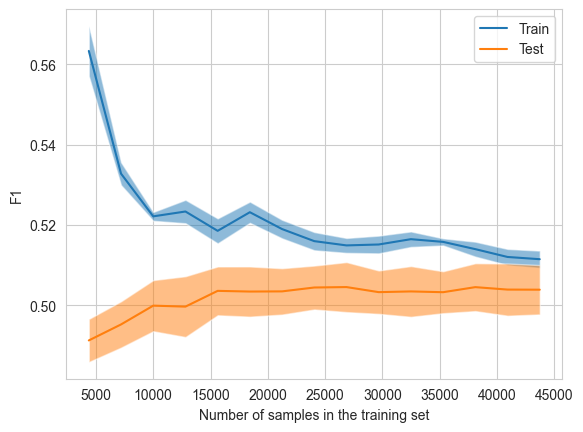

In [1408]:
LearningCurveDisplay.from_estimator(
   xgb_grid, X_train_tree, y_train, train_sizes=np.linspace(.1,1,15), cv=k_fold,scoring = 'f1' ,n_jobs=-1, random_state=seed)#score_name="Expected Profit per Email"

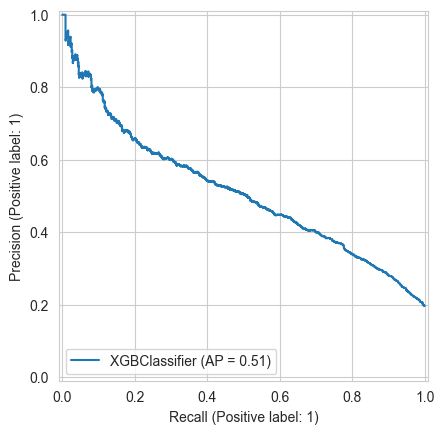

In [1409]:
PrecisionRecallDisplay.from_estimator(xgb_grid,X_val_tree,y_val)

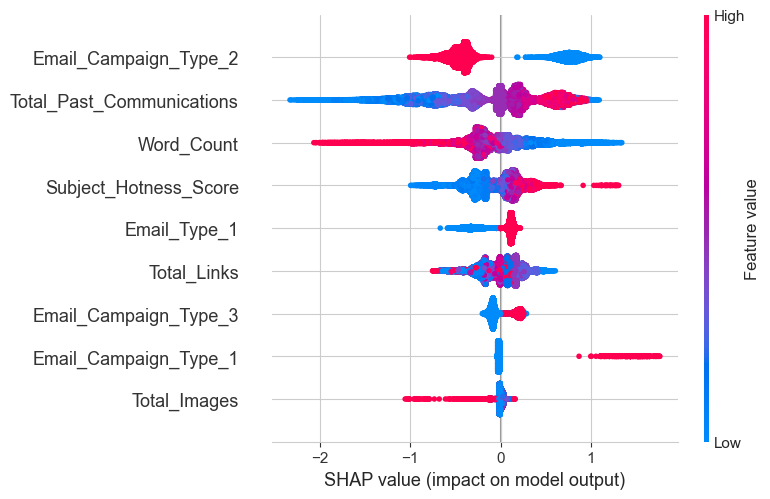

In [1410]:
explainer = shap.TreeExplainer(xgb_grid)
shaps = explainer.shap_values(X_train_tree)
shap.summary_plot(shaps, X_train_tree)

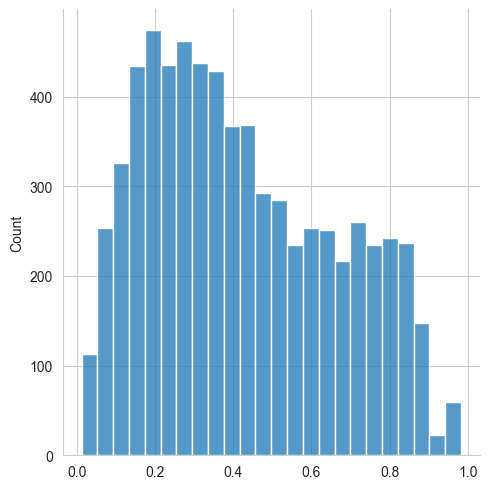

In [1411]:
sns.displot(xgb_grid.predict_proba(X_val_tree)[:, 1])

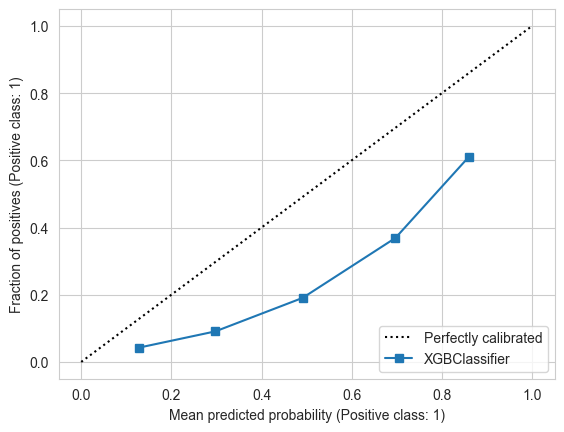

In [1412]:
CalibrationDisplay.from_estimator(xgb_grid,X_val_tree,y_val)

In [128]:
cal_xgb = CalibratedClassifierCV(FrozenEstimator(xgb_grid))
cal_xgb.fit(X_train_tree,y_train)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=XGBClassifier(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=0.75,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric='logloss',
                                                                         feature_types=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importance_type=None,
                                                                         interaction_constraints=None,
                                                                         learning_rate=0.08,
                                                                         max_bin=None,
                                                                         max_cat_threshold=None,
                                                                         max_cat_to_onehot=None,
                                                                         max_delta_step=None,
                                                                         max_depth=3,
                                                                         max_leaves=7,
                                                                         min_child_weight=3,
                                                                         missing=nan,
                                                                         monotone_constraints=None,
                                                                         multi_strategy=None,
                                                                         n_estimators=300,
                                                                         n_jobs=None,
                                                                         num_parallel_tree=None,
                                                                         random_state=23, ...)))

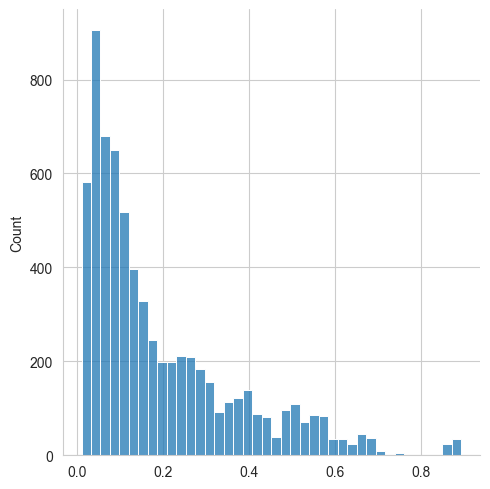

In [1414]:
sns.displot(cal_hgb.predict_proba(X_val_tree)[:, 1])

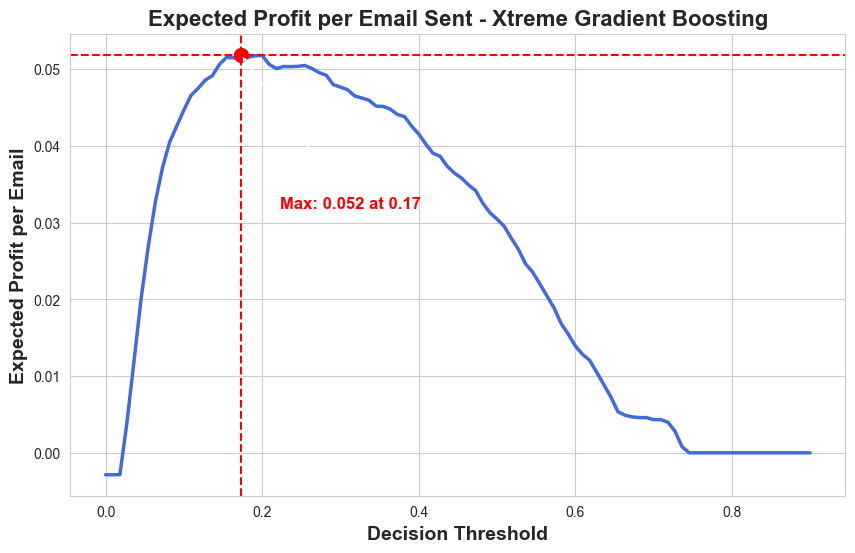

[np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(0.003972201901975141),
 np.float64(0.012048280907095834),
 np.float64(0.020190197512801756),
 np.float64(0.026927578639356263),
 np.float64(0.03274323335771764),
 np.float64(0.03717629846378932),
 np.float64(0.040490124359912213),
 np.float64(0.042574981711777614),
 np.float64(0.044659839063643014),
 np.float64(0.04656912948061449),
 np.float64(0.04749085588880761),
 np.float64(0.04854425749817118),
 np.float64(0.04913679590343819),
 np.float64(0.05060716898317484),
 np.float64(0.05152889539136796),
 np.float64(0.051441111923921),
 np.float64(0.051858083394294076),
 np.float64(0.05152889539136796),
 np.float64(0.05172640819312363),
 np.float64(0.05177029992684711),
 np.float64(0.0505852231163131),
 np.float64(0.05005852231163131),
 np.float64(0.0503218727139722),
 np.float64(0.05029992684711046),
 np.float64(0.05034381858083395),
 np.float64(0.05045354791514265),
 

In [129]:
ev_per_email(cal_xgb, X_val_tree, y_val, "Xtreme Gradient Boosting")

In [130]:
# Threshold subject to change 
xgb_thresh = .17
cal_y = (cal_hgb.predict_proba(X_val_tree)[:,1] >= xgb_thresh)#.astype(int)
print(classification_report(y_val,cal_y))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      5494
           1       0.37      0.74      0.50      1341

    accuracy                           0.71      6835
   macro avg       0.65      0.72      0.64      6835
weighted avg       0.81      0.71      0.73      6835



### Ensemble Models

Quickly we can see if ensembling our models together would allow for differences in errors/pattern recognition to get a little more juice out. 
* We can try soft voting, hard voting, and stacking ensembles to try for different ways to allow the decision to be made
* Does not seem like ensembling adds any value as far as optimized profit goes, but worth trying.

In [132]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score

In [134]:
voting_clf = VotingClassifier(estimators=[
    ('rf', cal_hgb), ('hgb', cal_hgb), ('xgb', cal_xgb)],
    voting='soft')  # 'hard' for majority voting
voting_clf.fit(X_train_tree, y_train)
y_pred_voting = voting_clf.predict_proba(X_val_tree)[:,1] >= .17
print("Voting F1 Score:", f1_score(y_val, y_pred_voting))
print(classification_report(y_val,cal_y))

Voting F1 Score: 0.5059208868732679
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      5494
           1       0.37      0.74      0.50      1341

    accuracy                           0.71      6835
   macro avg       0.65      0.72      0.64      6835
weighted avg       0.81      0.71      0.73      6835



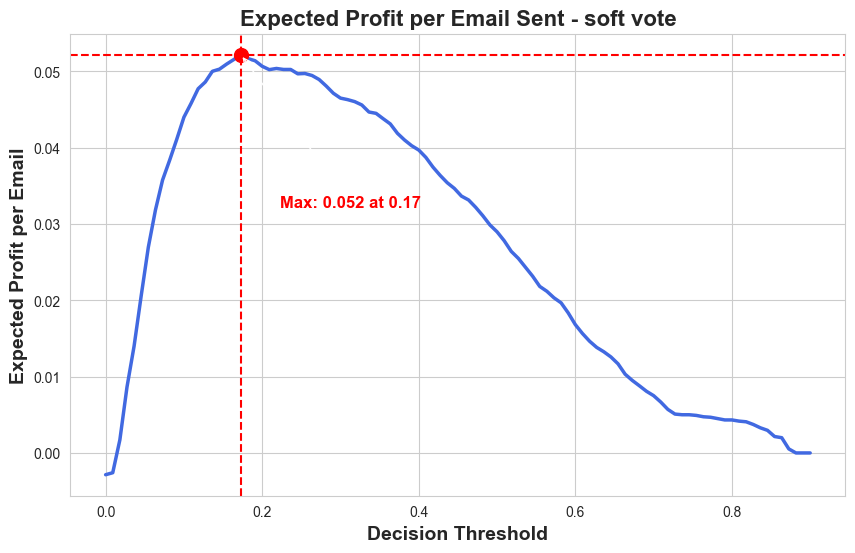

[np.float64(-0.0028529626920263352),
 np.float64(-0.0025896122896854326),
 np.float64(0.0017117776152158076),
 np.float64(0.008624725676664235),
 np.float64(0.01400146305779079),
 np.float64(0.02060716898317484),
 np.float64(0.026949524506218),
 np.float64(0.03182150694952451),
 np.float64(0.03574981711777615),
 np.float64(0.038361375274323345),
 np.float64(0.04110460863204097),
 np.float64(0.043979517190929046),
 np.float64(0.0457790782735918),
 np.float64(0.04771031455742502),
 np.float64(0.04858814923189466),
 np.float64(0.04999268471104609),
 np.float64(0.05027798098024872),
 np.float64(0.05093635698610095),
 np.float64(0.05152889539136796),
 np.float64(0.05216532553035845),
 np.float64(0.05166057059253841),
 np.float64(0.05137527432333577),
 np.float64(0.050651060716898316),
 np.float64(0.050212143379663496),
 np.float64(0.050365764447695686),
 np.float64(0.05023408924652524),
 np.float64(0.05023408924652524),
 np.float64(0.04966349670811997),
 np.float64(0.049707388441843456),
 n

In [135]:
ev_per_email(voting_clf,X_val_tree,y_val,'soft vote')

In [136]:
# Custom Hard Voting with Custom Threshold
threshold = 0.16  # Adjust this based on precision-recall balance
probs_rf = cal_rf.predict_proba(X_val_tree)[:, 1]
probs_hgb = cal_hgb.predict_proba(X_val_tree)[:, 1]
probs_xgb = cal_xgb.predict_proba(X_val_tree)[:, 1]

# Average probabilities from all models
avg_probs = (probs_rf + probs_hgb + probs_xgb) / 3

# Apply custom threshold
y_pred_custom_hard = (avg_probs >= threshold).astype(int)

print("Custom Hard Voting F1 Score:", f1_score(y_val, y_pred_custom_hard))

Custom Hard Voting F1 Score: 0.49691281797974807


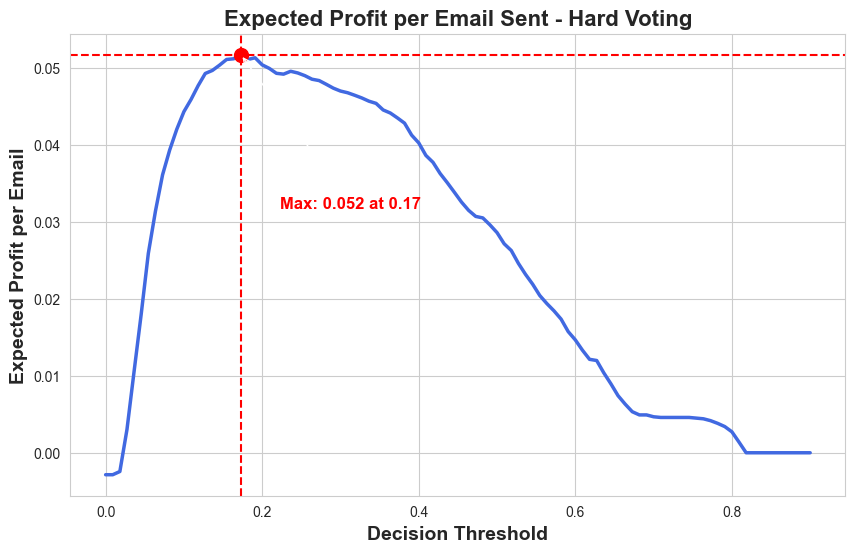

In [137]:
ev_list = []
thresh_list = np.linspace(0, 0.9, 100)  # More resolution in threshold steps

for i in thresh_list:
    y_pred = avg_probs
    score = ev_scorer(y_val, avg_probs, i)
    ev_list.append(score)
    # print(score)

# Find max value and corresponding threshold
max_ev = max(ev_list)
max_thresh = thresh_list[np.argmax(ev_list)]

# Set presentation-friendly style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot line
sns.lineplot(x=thresh_list, y=ev_list, linewidth=2.5, color="royalblue")

# Highlight max point
plt.axhline(y=max_ev, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(x=max_thresh, color='red', linestyle='dashed', linewidth=1.5)
plt.scatter(max_thresh, max_ev, color='red', s=100, zorder=3)

# Annotate max point
plt.annotate(f'Max: {max_ev:.3f} at {max_thresh:.2f}', 
                xy=(max_thresh, max_ev), 
                xytext=(max_thresh + 0.05, max_ev - 0.02), 
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12, fontweight='bold', color='red')

# Labels and title
plt.xlabel('Decision Threshold', fontsize=14, fontweight='bold')
plt.ylabel('Expected Profit per Email', fontsize=14, fontweight='bold')
plt.title(f"Expected Profit per Email Sent - Hard Voting", fontsize=16, fontweight='bold')

# Show plot
plt.show()

In [138]:
# Stacking Classifier (Meta-Learner)
stacking_clf = StackingClassifier(
    estimators=[('rf', cal_rf), ('hgb', cal_hgb), ('xgb', cal_xgb)],
    # final_estimator=LogisticRegression(),
    stack_method='predict_proba')  # Use 'auto' or 'predict' if needed
stacking_clf.fit(X_train_tree, y_train)
y_pred_stacking = (stacking_clf.predict_proba(X_val_tree)[:,1] >= .15).astype(int)#[:, 1]
print("Stacking F1 Score:", f1_score(y_val, y_pred_stacking))

Stacking F1 Score: 0.5080284285338247


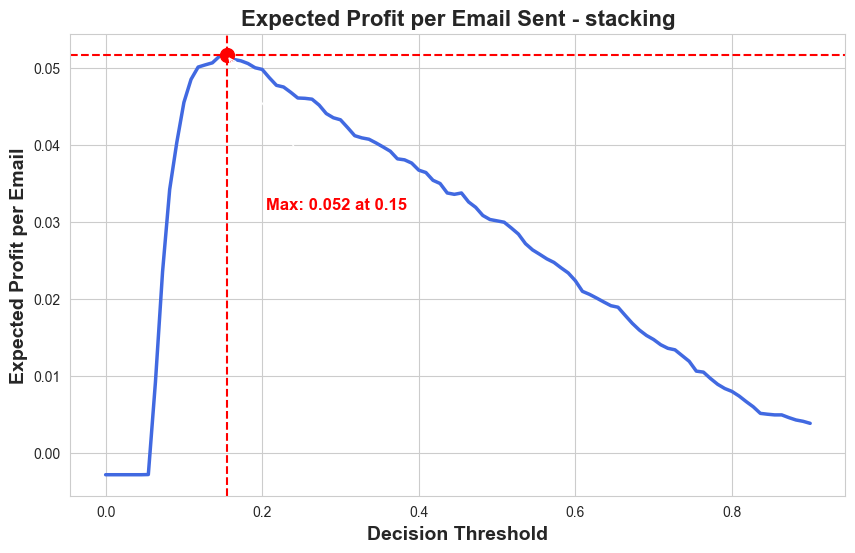

[np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028529626920263352),
 np.float64(-0.0028310168251645808),
 np.float64(0.009195318215069498),
 np.float64(0.02350402340892465),
 np.float64(0.034191660570592544),
 np.float64(0.04029261155815654),
 np.float64(0.04549378200438918),
 np.float64(0.04847841989758596),
 np.float64(0.05008046817849305),
 np.float64(0.050365764447695686),
 np.float64(0.05062911485003658),
 np.float64(0.05148500365764448),
 np.float64(0.05168251645940015),
 np.float64(0.0510680321872714),
 np.float64(0.05089246525237747),
 np.float64(0.05054133138258961),
 np.float64(0.049992684711046086),
 np.float64(0.049773226042428675),
 np.float64(0.04869787856620337),
 np.float64(0.04771031455742502),
 np.float64(0.04749085588880761),
 np.float64(0.04681053401609364),
 np.float64(0.046064374542794446),
 np.float64(0.04602048

In [139]:
ev_per_email(stacking_clf,X_val_tree,y_val,model_name='stacking')

# Test Data Results

After retraining the model on both the validation and the training set in order to see how it performs on the test set at their respective probability thresholds we see some interesting results:

* Models have nearly identical F1 scores and AP scores, but they get there very differently. RF and XGB prefer higher Recall while HGB prefers higher precision. However, as we will see in the model visualization section, they all are able to optimize the profit function at the same level.
* We will refit the models to include the validation data as part of training so that we can appropriately gauge test performance
    * Compared to the results during model training/validation they all perform very similarly on the test data, so this indicates good fits and model stability


In [179]:
from sklearn.metrics import average_precision_score

In [348]:
X_train_all = pd.concat([X_train,X_val])
y_train_all = pd.concat([y_train,y_val])


X_train_lin_all = preprocessor.fit_transform(X_train_all)
X_train_lin_all.columns = X_train_lin_all.columns.str.split('__').str[-1]
X_train_lin_all = poly_preprocess.fit_transform(X_train_lin_all)
X_train_lin_all.columns = X_train_lin_all.columns.str.split('__').str[-1]
X_train_lin_all = X_train_lin_all[features["Feature"]]

X_test_lin = preprocessor.transform(X_test)
X_test_lin.columns = X_test_lin.columns.str.split('__').str[-1]
X_test_lin = poly_preprocess.transform(X_test_lin)
X_test_lin.columns = X_test_lin.columns.str.split('__').str[-1]
X_test_lin = X_test_lin[features["Feature"]]

X_train_tree_all = preprocessor_tree.fit_transform(X_train_all)
X_train_tree_all.columns = X_train_tree_all.columns.str.split('__').str[-1]
X_train_tree_all = X_train_tree_all[tree_features]
X_test_tree = preprocessor_tree.transform(X_test)
X_test_tree.columns = X_test_tree.columns.str.split('__').str[-1]
X_test_tree = X_test_tree[tree_features].copy()

In [352]:
round(average_precision_score(y_test,dumb.predict_proba(X_test_lin)[:,1]),3)

np.float64(0.197)

### Logistic Regression

In [349]:
cal_lr.fit(X_train_lin_all,y_train_all)
lr_grid.best_estimator_.fit(X_train_lin_all,y_train_all)

/Users/blakegilliland/Documents/Projects/residentComms/side-projects/credible_takehome/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(C=np.float64(166.81005372000558), class_weight='balanced',
                   l1_ratio=0.1, max_iter=5000, n_jobs=-1, penalty='l1',
                   random_state=23, solver='saga')

In [350]:
cal_y = (cal_lr.predict_proba(X_test_lin) > lr_thresh)[:,1]#.astype(int)
print(classification_report(y_test,cal_y))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78      5495
           1       0.36      0.75      0.49      1341

    accuracy                           0.69      6836
   macro avg       0.64      0.71      0.63      6836
weighted avg       0.81      0.69      0.72      6836



In [351]:
round(average_precision_score(y_test,cal_lr.predict_proba(X_test_lin)[:,1]),3)

np.float64(0.493)

### Random Forest

In [175]:
cal_rf.fit(X_train_tree_all,y_train_all)
rf_grid.fit(X_train_tree_all,y_train_all)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=60,
                       n_jobs=-1, random_state=23)

In [176]:
cal_y = (cal_rf.predict_proba(X_test_tree) > rf_thresh)[:,1]#.astype(int)
print(classification_report(y_test,cal_y))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      5495
           1       0.39      0.72      0.50      1341

    accuracy                           0.72      6836
   macro avg       0.65      0.72      0.66      6836
weighted avg       0.81      0.72      0.75      6836



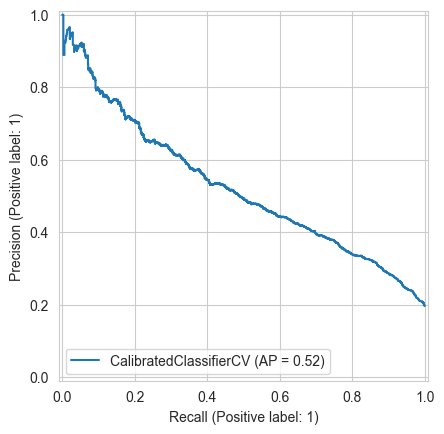

In [177]:
PrecisionRecallDisplay.from_estimator(cal_rf,X_test_tree,y_test)

In [180]:
round(average_precision_score(y_test,cal_rf.predict_proba(X_test_tree)[:,1]),3)

np.float64(0.524)

### Hist Gradient Boosting

In [182]:
cal_hgb.fit(X_train_tree_all,y_train_all)
hgb_grid.fit(X_train_tree_all,y_train_all)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=1,
                               learning_rate=0.3, max_depth=5, max_iter=200,
                               max_leaf_nodes=20, random_state=23,
                               scoring='f1')

In [183]:
cal_y = (cal_hgb.predict_proba(X_test_tree) > hgb_thresh)[:,1]#.astype(int)
print(classification_report(y_test,cal_y))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      5495
           1       0.38      0.72      0.50      1341

    accuracy                           0.71      6836
   macro avg       0.65      0.72      0.65      6836
weighted avg       0.81      0.71      0.74      6836



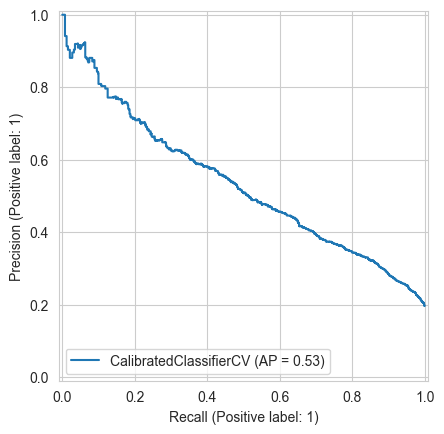

In [184]:
PrecisionRecallDisplay.from_estimator(cal_hgb,X_test_tree,y_test)

In [185]:
round(average_precision_score(y_test,cal_hgb.predict_proba(X_test_tree)[:,1]),3)

np.float64(0.534)

### XGBoost

In [186]:
cal_xgb.fit(X_train_tree_all,y_train_all)
xgb_grid.fit(X_train_tree_all,y_train_all)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=7, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=23, ...)

In [187]:
cal_y = (cal_xgb.predict_proba(X_test_tree) > xgb_thresh)[:,1]#.astype(int)
print(classification_report(y_test,cal_y))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      5495
           1       0.38      0.74      0.51      1341

    accuracy                           0.72      6836
   macro avg       0.65      0.72      0.65      6836
weighted avg       0.81      0.72      0.74      6836



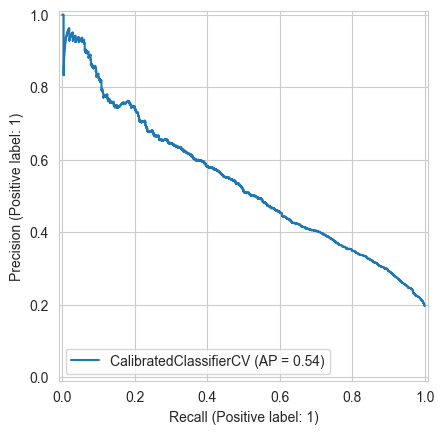

In [188]:
PrecisionRecallDisplay.from_estimator(cal_xgb,X_test_tree,y_test)

In [189]:
round(average_precision_score(y_test,cal_xgb.predict_proba(X_test_tree)[:,1]),3)

np.float64(0.539)

# Model visualization

Here we will create visualizations to indicate differences between models and how they are able to solve the business problem. These will be main focus of presentation. Some visualizations include:
* PR Curves
* PR/F1 vs Decision Threshold
* EV Profit vs Decision Threshold
* ROI Confusion Matrices
* Cumulative Gains Chart
* Will also include visualizations from other sections pertaining to feature importance such as SHAP values

In [191]:
from sklearn.metrics import precision_recall_curve

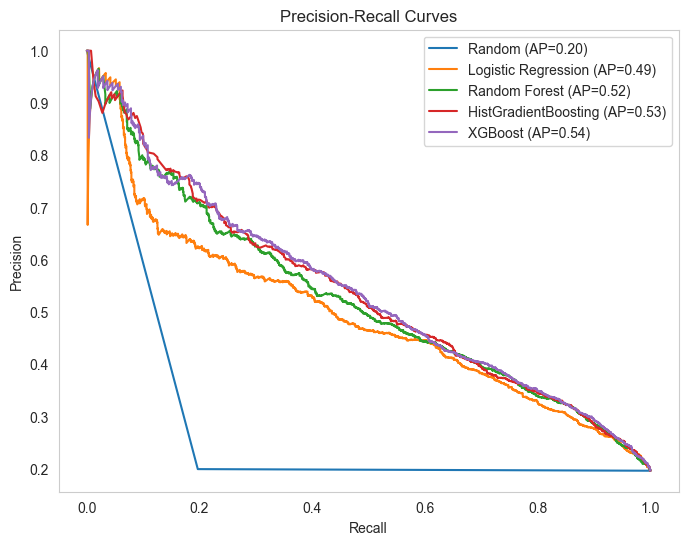

In [353]:
models = {
    "Random": (y_test, dumb.predict_proba(X_test_tree)[:,1]),
    "Logistic Regression": (y_test, cal_lr.predict_proba(X_test_lin)[:, 1]),
    "Random Forest": (y_test, cal_rf.predict_proba(X_test_tree)[:, 1]),
    "HistGradientBoosting": (y_test, cal_hgb.predict_proba(X_test_tree)[:, 1]),
    "XGBoost": (y_test, cal_xgb.predict_proba(X_test_tree)[:, 1]),
    # "Soft Vote Ensemble": (y_test,voting_clf.predict_proba(X_test_tree)[:, 1]),
    # "Hard Vote Ensemble": (y_test,avg_probs),
    # "Stacking Ensemble": (y_test,stacking_clf.predict_proba(X_test_tree)[:,1]),
    
}

plt.figure(figsize=(8, 6))

best_model = "XGBoost"
for model_name, (y_true, y_scores) in models.items():
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    # linewidth = 3 if model_name == best_model else 1.5  # Make best model stand out
    plt.plot(recall, precision, label=f"{model_name} (AP={avg_precision:.2f})", linewidth=1.5)


# Formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid()
plt.show()

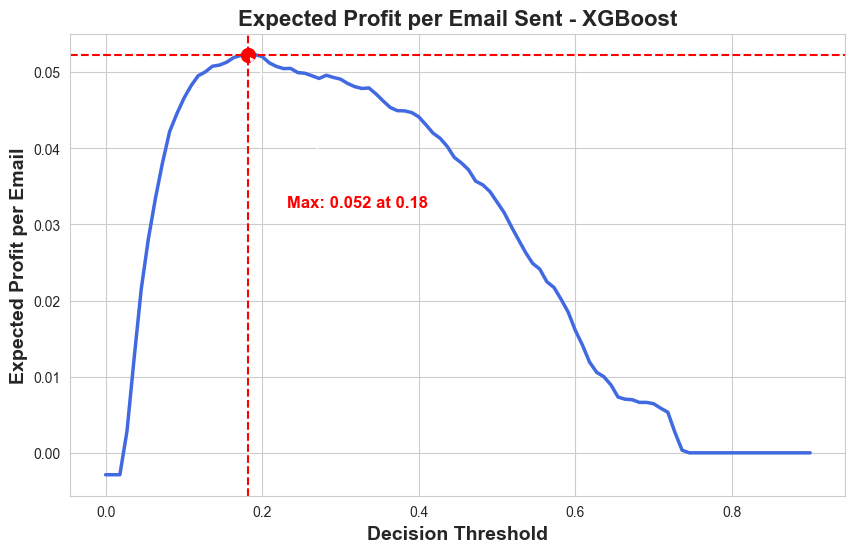

[np.float64(-0.0028744880046810803),
 np.float64(-0.0028744880046810803),
 np.float64(-0.0028744880046810803),
 np.float64(0.002830602691632537),
 np.float64(0.012375658279695731),
 np.float64(0.02148186073727326),
 np.float64(0.028064657694558223),
 np.float64(0.03344060854300761),
 np.float64(0.03813633703920422),
 np.float64(0.04221767115272089),
 np.float64(0.04452165008777063),
 np.float64(0.04656231714452897),
 np.float64(0.048208016383850215),
 np.float64(0.0495245757753072),
 np.float64(0.05002925687536571),
 np.float64(0.050775307197191345),
 np.float64(0.05092890579286133),
 np.float64(0.05130193095377414),
 np.float64(0.05191632533645407),
 np.float64(0.05220157987126975),
 np.float64(0.05228935049736688),
 np.float64(0.05228935049736688),
 np.float64(0.052047981275599765),
 np.float64(0.051214160327677005),
 np.float64(0.050753364540667055),
 np.float64(0.05046811000585138),
 np.float64(0.05049005266237566),
 np.float64(0.049941486249268585),
 np.float64(0.04985371562317144

In [197]:
ev_per_email(cal_xgb,X_test_tree,y_test,model_name="XGBoost")

In [358]:
def ev_per_email(model, X, Y):
    thresh_list = np.linspace(0, 0.9, 100)  # More resolution in threshold steps
    ev_list = [ev_scorer(Y, model.predict_proba(X)[:, 1], i) for i in thresh_list]

    # Return as DataFrame for structured data handling
    return pd.DataFrame({"threshold": thresh_list, "expected_value": ev_list})

In [359]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def prf1_thresh(model, thresh, X_test):
    # Get expected profit per email data using only test data
    ev_data = ev_per_email(model, X_test, y_test)

    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Precision, recall, and F1-score calculation
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Handle NaNs

    # Find closest indices for selected threshold
    chosen_threshold_index = np.argmin(np.abs(thresholds - thresh))
    chosen_threshold_index_ev = np.argmin(np.abs(ev_data["threshold"] - thresh))

    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))

    # Precision plot
    axes[0].plot(thresholds, precision[:-1], label='Precision', color='blue')
    axes[0].axvline(thresh, color='red', linestyle='--', label=f'Chosen ({thresh:.2f})')
    axes[0].axhline(precision[chosen_threshold_index], color='red', linestyle='--')
    axes[0].set_title('Precision vs. Threshold')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Precision')
    axes[0].legend()
    axes[0].set_ylim([0, 1])
    axes[0].set_xlim([0, 0.9])
    axes[0].text(thresh + 0.02, precision[chosen_threshold_index] - 0.05, 
                 f'{precision[chosen_threshold_index]:.2f}', color='red', fontsize=12)

    # Recall plot
    axes[1].plot(thresholds, recall[:-1], label='Recall', color='green')
    axes[1].axvline(thresh, color='red', linestyle='--', label=f'Chosen ({thresh:.2f})')
    axes[1].axhline(recall[chosen_threshold_index], color='red', linestyle='--')
    axes[1].set_title('Recall vs. Threshold')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Recall')
    axes[1].legend()
    axes[1].set_ylim([0, 1])
    axes[1].set_xlim([0, 0.9])
    axes[1].text(thresh + 0.02, recall[chosen_threshold_index] + 0.01, 
                 f'{recall[chosen_threshold_index]:.2f}', color='red', fontsize=12)

    # F1 Score plot
    axes[2].plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple')
    axes[2].axvline(thresh, color='red', linestyle='--', label=f'Chosen ({thresh:.2f})')
    axes[2].axhline(f1_scores[chosen_threshold_index], color='red', linestyle='--')
    axes[2].set_title('F1 Score vs. Threshold')
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].set_xlim([0, 0.9])
    axes[2].text(thresh + 0.02, f1_scores[chosen_threshold_index] - 0.03, 
                 f'{f1_scores[chosen_threshold_index]:.2f}', color='red', fontsize=12)

    # Expected Profit per Email plot
    axes[3].plot(ev_data["threshold"], ev_data["expected_value"], label='Expected Profit', color='royalblue')
    axes[3].axvline(thresh, color='red', linestyle='--', label=f'Chosen ({thresh:.2f})')
    axes[3].axhline(ev_data["expected_value"][chosen_threshold_index_ev], color='red', linestyle='--')
    axes[3].set_title('Expected Profit vs. Threshold')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Expected Profit')
    axes[3].legend()
    axes[3].set_xlim([0, 0.9])
    axes[3].text(thresh + 0.02, ev_data["expected_value"][chosen_threshold_index_ev] - 0.02, 
                 f'{ev_data["expected_value"][chosen_threshold_index_ev]:.3f}', color='red', fontsize=12)

    plt.tight_layout()
    plt.show()


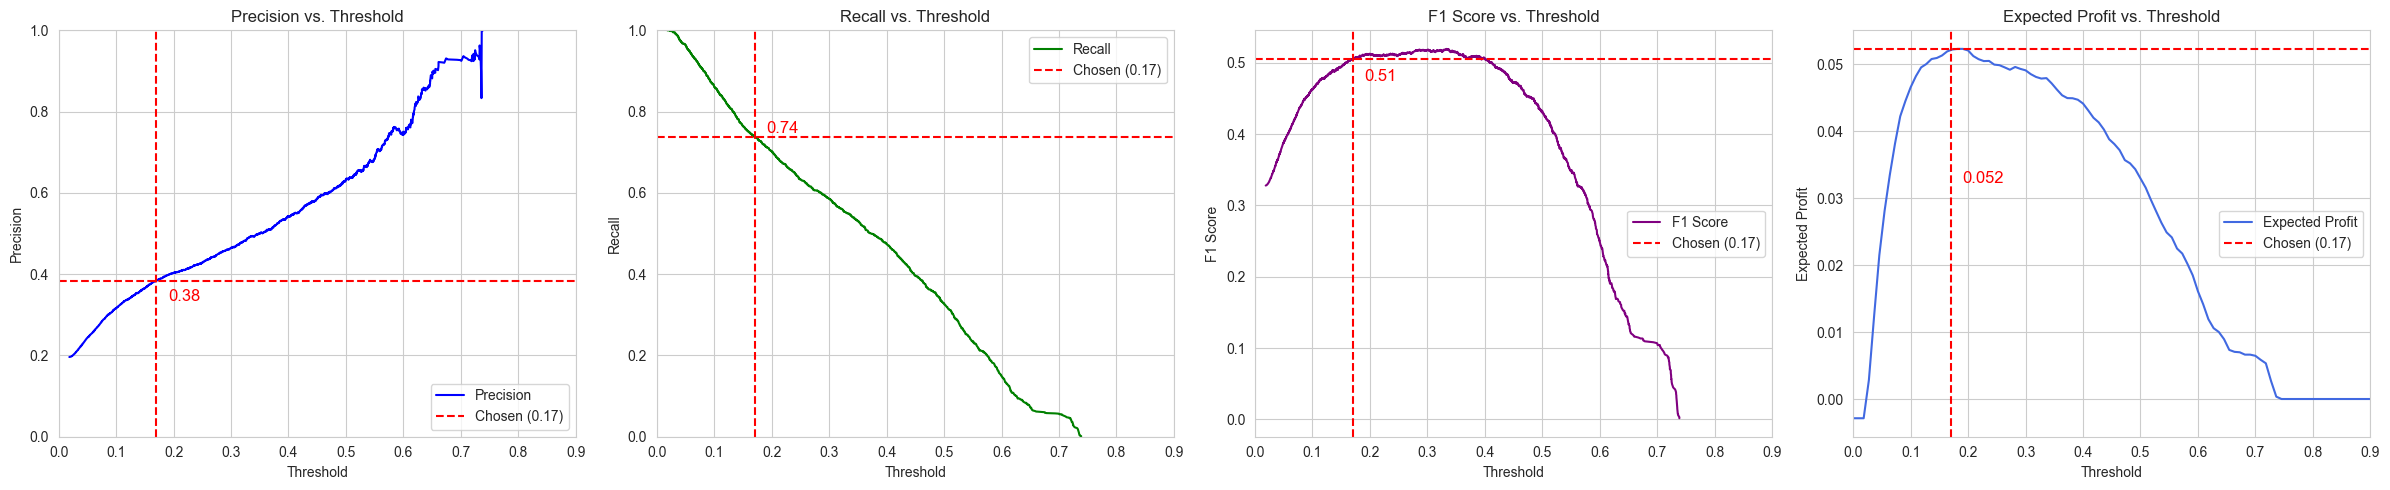

0.17

In [200]:
prf1_thresh(cal_xgb,xgb_thresh,X_test_tree)
xgb_thresh

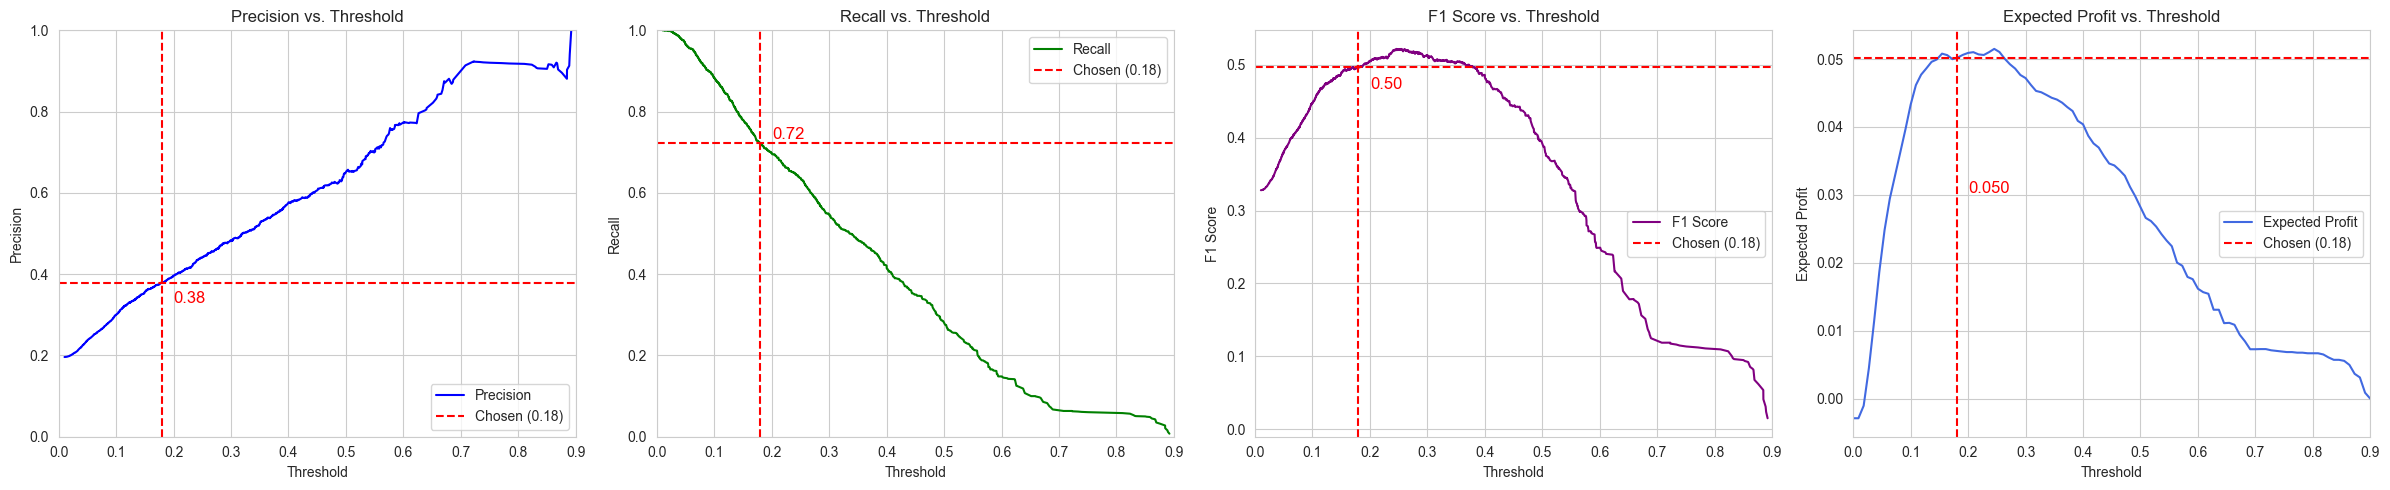

0.18

In [201]:
prf1_thresh(cal_hgb,hgb_thresh,X_test_tree)
hgb_thresh

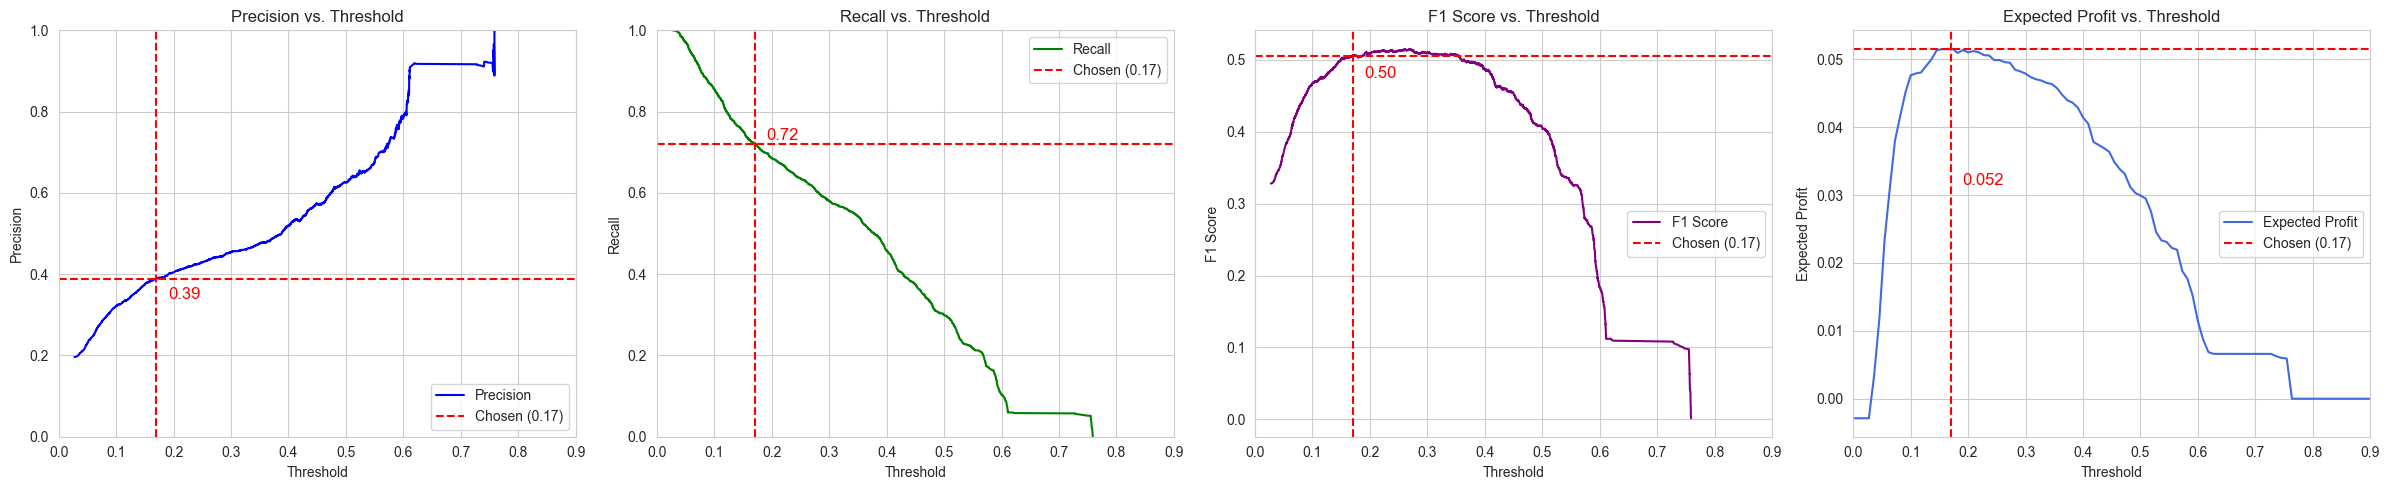

0.17

In [202]:
prf1_thresh(cal_rf,rf_thresh,X_test_tree)
rf_thresh

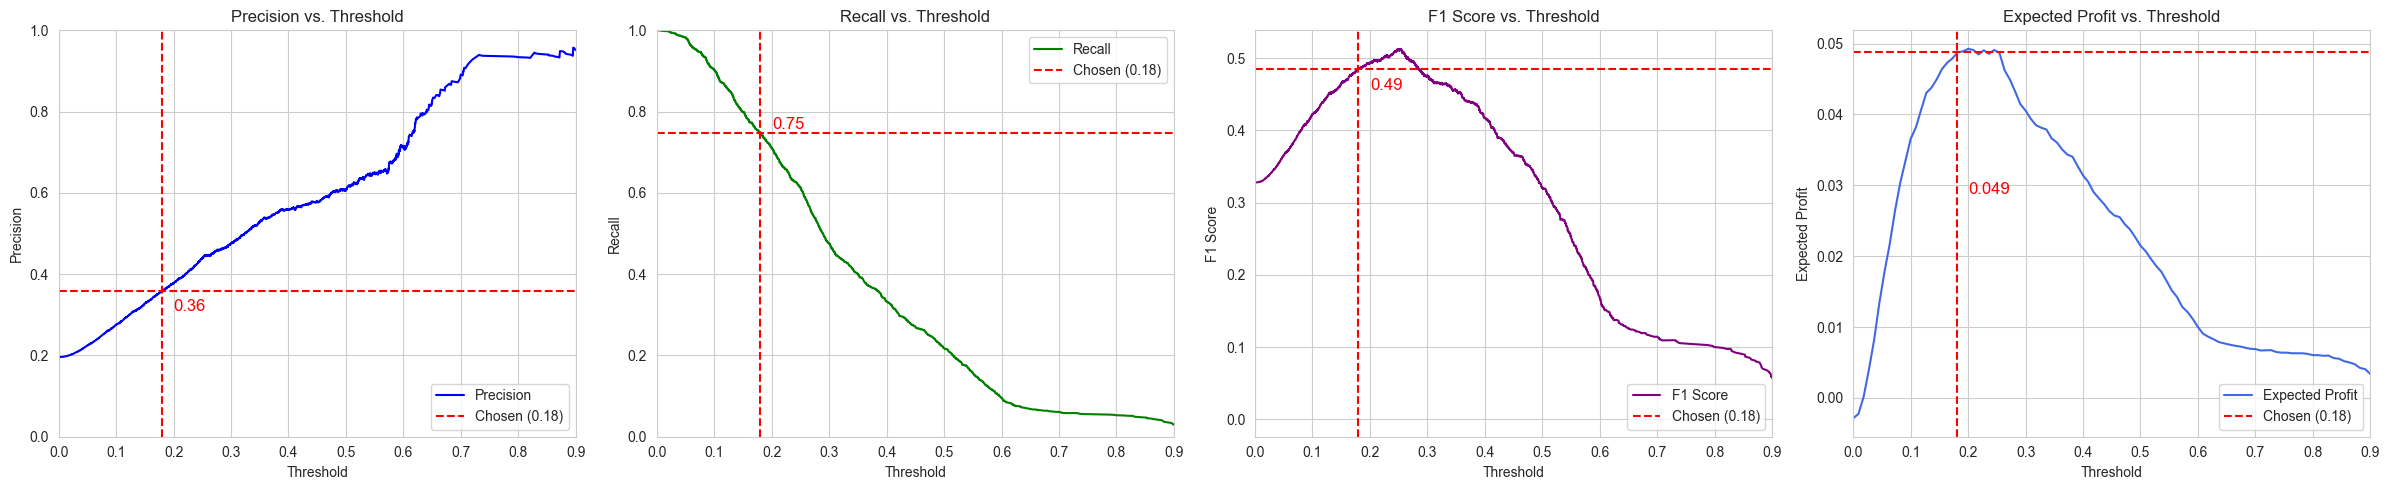

In [360]:
prf1_thresh(cal_lr,lr_thresh,X_test_lin)

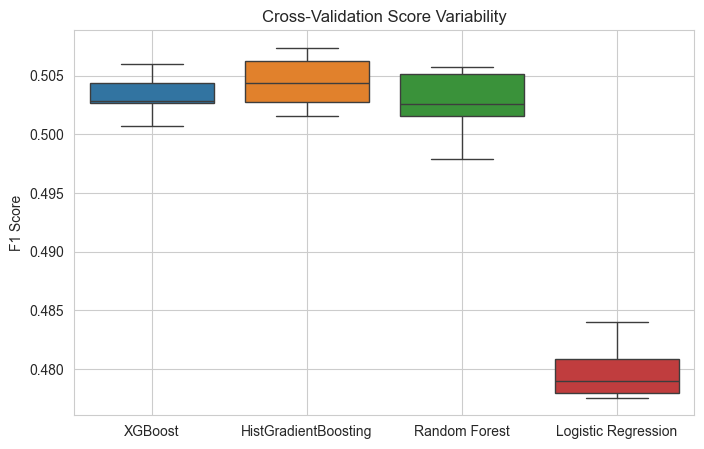

In [354]:
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

models = {
    "XGBoost": [cal_xgb, xgb_thresh],
    "HistGradientBoosting": [cal_hgb, hgb_thresh],
    "Random Forest": [cal_rf, rf_thresh],
    "Logistic Regression": [cal_lr, lr_thresh]
}

model_scores = {}

for model_name, model in models.items():
    
    def recall_with_threshold(y_true, y_probs, threshold=model[1]):
        y_preds = (y_probs >= threshold).astype(int)
        return f1_score(y_true, y_preds)
    custom_recall_scorer = make_scorer(recall_with_threshold, response_method='predict_proba')
    model_dat = X_train_lin_all if model_name == 'Logistic Regression' else X_train_tree_all
    # print(model)
    scores = cross_val_score(model[0], model_dat, y_train_all, cv=k_fold, scoring=custom_recall_scorer, n_jobs=-1)
    model_scores[model_name] = scores

# Convert to DataFrame for Seaborn
import pandas as pd
df = pd.DataFrame(model_scores)

# Plot a boxplot of CV scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=df)
plt.ylabel("F1 Score")
plt.title("Cross-Validation Score Variability")
plt.grid(True)
plt.show()


In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def cumulative_gains_chart(models, X_test, y_test, names):
    plt.figure(figsize=(8,6))
    
    for model, name in zip(models, names):
        X_test_for = X_test[1] if name == 'Logistic Regression' else X_test[0]
        y_probs = model.predict_proba(X_test_for)[:, 1]
        data = pd.DataFrame({'y_true': y_test, 'y_prob': y_probs})
        data = data.sort_values(by='y_prob', ascending=False)

        data['cumulative_positive'] = data['y_true'].cumsum() / data['y_true'].sum()
        data['cumulative_population'] = np.arange(1, len(data) + 1) / len(data)
        
        plt.plot(data['cumulative_population'], data['cumulative_positive'], label=name)
    
    # Random Model line
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', label="Random Model")
    
    plt.xlabel("Cumulative % of Population")
    plt.ylabel("Cumulative % of Clicks")
    plt.title("Cumulative Gains Chart")
    plt.legend()
    plt.grid()
    plt.show()


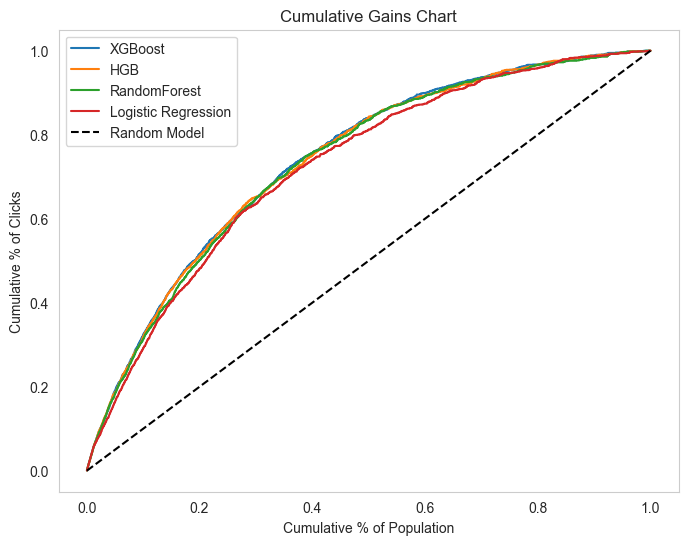

In [356]:
cumulative_gains_chart([cal_xgb, cal_hgb, cal_rf, cal_lr],[X_test_tree, X_test_lin],y_test, ['XGBoost', 'HGB', 'RandomForest',"Logistic Regression"])

In [1396]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def cost_benefit_heatmap(model, X_test, y_test, cost_per_email=0.15, revenue_per_click=0.75):
    thresholds = np.linspace(0, 1, 50)
    costs = np.linspace(0.11, 0.2, 10)  # Different email costs
    
    y_probs = model.predict_proba(X_test)[:, 1]
    
    profit_matrix = np.zeros((len(costs), len(thresholds)))
    
    for i, cost in enumerate(costs):
        for j, threshold in enumerate(thresholds):
            y_pred = (y_probs >= threshold).astype(int)
            TP = np.sum((y_pred == 1) & (y_test == 1))  # True Positives
            FP = np.sum((y_pred == 1) & (y_test == 0))  # False Positives
            
            total_profit = (TP * revenue_per_click) - ((TP + FP) * cost)
            profit_matrix[i, j] = total_profit
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(profit_matrix, xticklabels=np.round(thresholds, 2), yticklabels=np.round(costs, 3),
                cmap="coolwarm", annot=False)
    
    plt.xlabel("Decision Threshold")
    plt.ylabel("Cost per Email ($)")
    plt.title("Cost-Benefit Analysis Heatmap")
    plt.show()


In [ ]:
cost_benefit_heatmap(cal_hgb,X_test_tree,y_test)

In [ ]:
cost_benefit_heatmap(cal_hgb,X_test_tree,y_test)

In [ ]:
cost_benefit_heatmap(cal_rf,X_test_tree,y_test)

In [1397]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def roi_confusion_matrix(model, X_test, y_test, threshold, cost_per_email=0.15, revenue_per_click=0.75):
    y_probs = model.predict_proba(X_test)[:, 1]
    # threshold = 0.5  # Use an optimized threshold if needed
    y_pred = (y_probs >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Define business impact per cell
    business_impact = np.array([
        [TN * 0, FP * (-cost_per_email)],  # TN, FP
        [FN * 0, TP * (revenue_per_click - cost_per_email)]  # FN, TP
    ])

    labels = np.array([
        [f"TN: {TN}\n$0", f"FP: {FP}\n-${FP * cost_per_email:.2f}"],
        [f"FN: {FN}\n$0", f"TP: {TP}\n+${TP * (revenue_per_click - cost_per_email):.2f}"]
    ])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(business_impact, annot=labels, fmt='', cmap="coolwarm", cbar=False, linewidths=1, linecolor="black")
    
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.xticks([0.5, 1.5], ["No Click", "Click"])
    plt.yticks([0.5, 1.5], ["No Click", "Click"], rotation=0)
    plt.title(f"ROI Impact Confusion Matrix (Threshold={threshold})")
    plt.show()


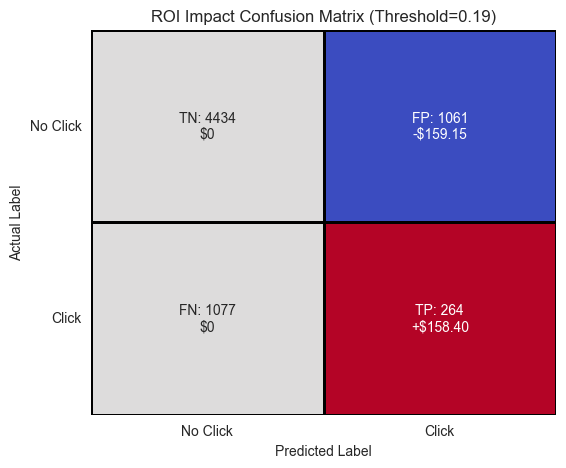

In [1439]:
roi_confusion_matrix(dumb,X_test_tree,y_test,.19)

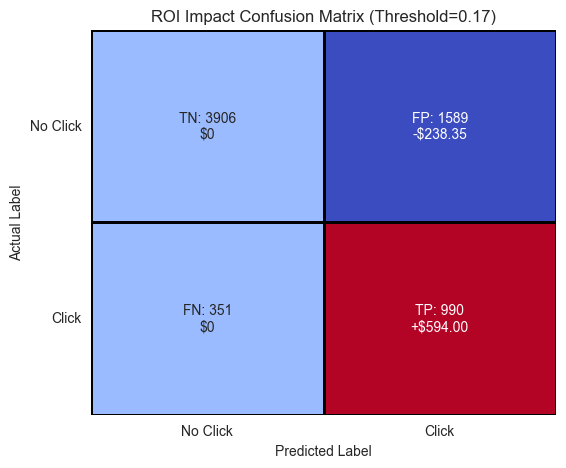

In [1398]:
roi_confusion_matrix(cal_xgb,X_test_tree,y_test,xgb_thresh)

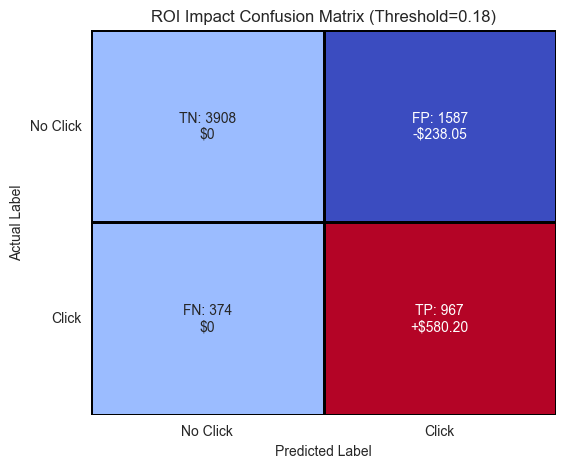

In [1399]:
roi_confusion_matrix(cal_hgb,X_test_tree,y_test,hgb_thresh)

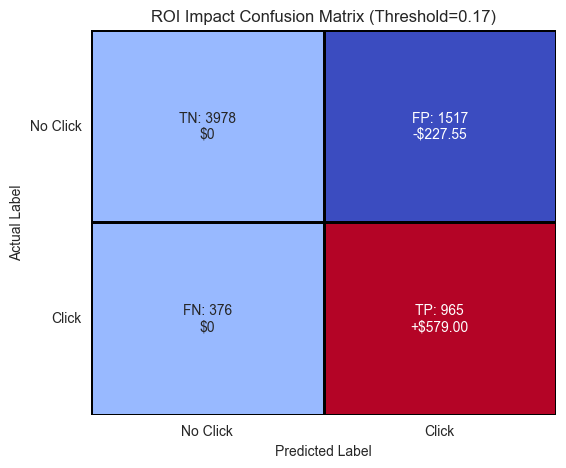

In [1400]:
roi_confusion_matrix(cal_rf,X_test_tree,y_test,rf_thresh)

In [1418]:
X_train_tree.columns

Index(['Total_Past_Communications', 'Email_Campaign_Type_2', 'Word_Count',
       'Email_Campaign_Type_3', 'Email_Campaign_Type_1', 'Total_Links',
       'Subject_Hotness_Score', 'Email_Type_1', 'Total_Images'],
      dtype='object')

In [ ]:
# Partial Dependence plots
from sklearn.inspection import PartialDependenceDisplay
for i in X_train_tree.columns:
    for j in X_train_tree.columns:
        if i != j:
            features_to_analyze = [(i, j)]  # Replace with actual feature names
            PartialDependenceDisplay.from_estimator(cal_xgb, X_test_tree, features_to_analyze)


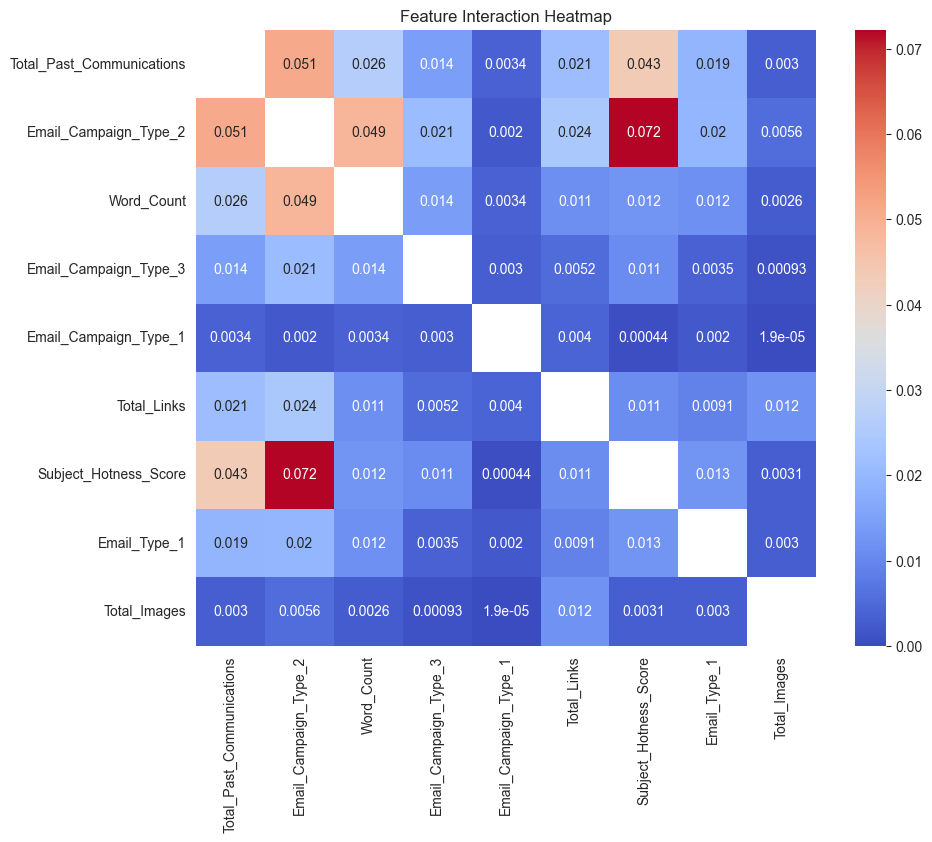

In [1449]:
import shap

explainer = shap.TreeExplainer(xgb_grid)
interaction_values = explainer.shap_interaction_values(X_test_tree)

# Plot interaction between two features
interaction_matrix = np.abs(interaction_values).mean(axis=0)
mask = np.eye(interaction_matrix.shape[0], dtype=bool)

# Plot heatmap
sns.set_style('white')
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, xticklabels=X_test_tree.columns, yticklabels=X_test_tree.columns, cmap="coolwarm", mask=mask, annot=True,vmin=0)
# sns.heatmap(interaction_matrix, xticklabels=X_test_tree.columns, yticklabels=X_test_tree.columns, cmap="coolwarm", annot=True,vmin=0)

plt.title("Feature Interaction Heatmap")
plt.show()

In [ ]:
def get_top_shap_interactions(model, X, top_n=5):
    # Compute SHAP interaction values
    explainer = shap.TreeExplainer(model)
    interaction_values = explainer.shap_interaction_values(X)
    
    # Compute mean absolute interaction matrix
    interaction_matrix = np.abs(interaction_values).mean(axis=0)
    
    # Extract diagonal (self-importance) values
    diag_values = np.diag(interaction_matrix)
    
    # Normalize interactions by the max of both features' self-importance
    normalized_matrix = interaction_matrix / np.maximum(diag_values[:, None], diag_values[None, :])
    
    # Convert to DataFrame
    features = X.columns
    interaction_df = pd.DataFrame(normalized_matrix, index=features, columns=features)

    # Mask diagonal (self-interaction)
    np.fill_diagonal(normalized_matrix, 0)

    # Get top interactions
    top_interactions = interaction_df.unstack().sort_values(ascending=False).head(top_n)
    return top_interactions

# Example usage:
top_interactions = get_top_shap_interactions(xgb_grid, X_test_tree, top_n=10)
print(top_interactions)


Email_Campaign_Type_2      Subject_Hotness_Score        0.141909
Subject_Hotness_Score      Email_Campaign_Type_2        0.141909
Total_Past_Communications  Email_Campaign_Type_2        0.105775
Email_Campaign_Type_2      Total_Past_Communications    0.105775
                           Word_Count                   0.087138
Word_Count                 Email_Campaign_Type_2        0.087138
Subject_Hotness_Score      Total_Past_Communications    0.084617
Total_Past_Communications  Subject_Hotness_Score        0.084617
Subject_Hotness_Score      Email_Campaign_Type_3        0.080916
Email_Campaign_Type_3      Subject_Hotness_Score        0.080916
dtype: float32
